# School shootings paper

Some bibliography: https://www.mendeley.com/community/school-shootings-bib-(until-2015)

In [86]:
import sys
import os
from IPython.display import clear_output
sys.path.append('./')

from shutil import copyfile
from multiprocessing import Pool
import pickle
import pandas as pd
#from numberAttacks import *
from helper_functions import *
from pylab import *
#from cosas import *
from datetime import datetime, timedelta
import scipy
from scipy.stats import lognorm

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

%matplotlib inline

In [118]:
import seaborn.apionly as sns
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

# Part1 .
Figure 1: Escalation patterns in school shootings. (A) Complementary Cumulative Distri- bution Function (CCDF) for event severity (dots and solid line) and best fit (dashed line) to power-law distribution. Note that the USA Today database only include attacks with four or more victims. (B) CCDF for normalized interevent times (dots and solid line). Inset show the CCDF of the raw intereven times. (C) Probability of attack depending on the presence of an attack in the previous seven days. Each bin contains one sixth of the attacks. (D-F) The esca-
lation plot, log10 n vs. log10 τn, for (D) All, (E) College and (F) K-12 attacks using the Schulz database (Methods). LOWESS fit (δ = 0, α = 0.66) is shown in dark gray, with the years where the trend changes annotated

In [8]:
miami_data = pd.read_csv("./data/alyssa_formatted.tsv",sep="\t",parse_dates=["date"]).sort_values(by="date")
everytown_data = pd.read_csv("./data/everytown_formatted.tsv",sep="\t",parse_dates=["date"]).sort_values(by="date")
miami_u_data = pd.read_csv("./data/alyssa_u_formatted.tsv",sep="\t",parse_dates=["date"]).sort_values(by="date")
everytown_u_data = pd.read_csv("./data/everytown_u_formatted.tsv",sep="\t",parse_dates=["date"]).sort_values(by="date")
usatoday_data = pd.read_csv("./data/usatoday_formatted.tsv",sep="\t",parse_dates=["date"]).sort_values(by="date")

def get_time_between_attacks(data):
    a = [n.astype('timedelta64[D]') / np.timedelta64(1, 'D') for n in np.diff(data["date"])]
    daysBetweenKills = np.asarray(a)

    daysBetweenKills[daysBetweenKills==0] += 0.1
    #Separate attacks in the same day
    while(np.any(np.diff(daysBetweenKills)==0)):
        daysBetweenKills[np.concatenate([[False],np.diff(daysBetweenKills)==0])] += 0.1
    return daysBetweenKills

daysBetweenKills = get_time_between_attacks(miami_data)
miami_data["time_from_previous_attacks"] = np.concatenate([[np.NaN],daysBetweenKills])
miami_data["time_to_next_attacks"] = np.concatenate([daysBetweenKills,[np.NaN]])

daysBetweenKills = get_time_between_attacks(miami_u_data)
miami_u_data["time_from_previous_attacks"] = np.concatenate([[np.NaN],daysBetweenKills])
miami_u_data["time_to_next_attacks"] = np.concatenate([daysBetweenKills,[np.NaN]])

daysBetweenKills = get_time_between_attacks(everytown_data)
everytown_data["time_from_previous_attacks"] = np.concatenate([[np.NaN],daysBetweenKills])
everytown_data["time_to_next_attacks"] = np.concatenate([daysBetweenKills,[np.NaN]])

daysBetweenKills = get_time_between_attacks(everytown_u_data)
everytown_u_data["time_from_previous_attacks"] = np.concatenate([[np.NaN],daysBetweenKills])
everytown_u_data["time_to_next_attacks"] = np.concatenate([daysBetweenKills,[np.NaN]])

daysBetweenKills = get_time_between_attacks(usatoday_data)
usatoday_data["time_from_previous_attacks"] = np.concatenate([[np.NaN],daysBetweenKills])
usatoday_data["time_to_next_attacks"] = np.concatenate([daysBetweenKills,[np.NaN]])



In [9]:
def plotCCDF(data,variable="number_victims",fit="powerlaw",normalize=False,ax=None,color=(73./256, 142./256, 204./256)):
    """
    Figure 1A Paper (Dec 19)
    Finds xmin and plot CCDF
    """
    sizeEvent = data[variable].values
    sizeEvent = np.round(sizeEvent[np.isfinite(sizeEvent)],0)
    [xCCDF,yCCDF,PDF] = get_CCDF(sizeEvent)
    if normalize == True:
        xCCDF /= np.mean(xCCDF)
    
    print("Median event", np.median(sizeEvent))
    if fit == "powerlaw":
        xmin = findXmin(sizeEvent)
        plotGlobalPL(sizeEvent,xmin=1,ax=ax,color=color)
        plotGlobalPL(sizeEvent,xmin=xmin,ax=ax,color=color)
    elif fit == "lognormal":
        plotGlobalLN(sizeEvent,ax=ax)
    else:
        plt.plot((xCCDF),(yCCDF),'.-',color=color,linewidth=2,markersize=10)
        plt.xscale("log")
        plt.yscale("log")
    return ax

In [10]:
def probability_attack(data,figname=None,nbins=6):
    bins = [np.ceil(_) for _ in np.linspace(0,100,nbins)]
    data["Time to next attack"] = pd.cut(data["time_to_next_attacks"],np.nanpercentile(data["time_to_next_attacks"],bins))
    data = data.dropna(subset=["time_from_previous_attacks","time_to_next_attacks"])
    data["Attack in the previous 7 days"] = data["time_from_previous_attacks"]<7
    data["freq"] = 1
    data["sum_group"] = data.groupby("Attack in the previous 7 days").transform(np.sum)["freq"]
    data["freq"] /= data["sum_group"]
    data["freq"] *= 100
    fig = plt.figure(figsize=(4.5,3.))
    ax =  fig.add_subplot(1,1,1)

    import statsmodels
    for g,d in data.groupby("Time to next attack"):
        for a,d2 in d.groupby("Attack in the previous 7 days"):
            print(g,a,statsmodels.stats.proportion.proportion_confint(len(d2),nobs=len(d),method="beta"))

    sns.barplot(x="Time to next attack",y="freq",hue="Attack in the previous 7 days",data=data,estimator=np.sum)
    plt.ylabel("Probability of an attack",fontsize=12)
    plt.xlabel("Time to next attack",fontsize=12)

    categ = data["Time to next attack"].unique()

    intervals = []
    for i in categ.categories.get_values():
        l,r = str(i)[1:-2].split(", ")
        if l == "0.1":
            l = 0
        l,r = np.ceil(float(l)),np.ceil(float(r))
        interval = "{:2.0f} -{:2.0f}".format(l,r)
        intervals.append(interval)

    plt.xticks(range(len(intervals)),intervals,fontsize=12)
    
    customaxis(ax,size=11,lw=2)
    if figname is not None:
        plt.savefig(figname, bbox_inches='tight' ,dpi=100)
    plt.show()
    

In [43]:
def red_vs_blue(data,type_attacks="All",variable="time_to_next_attacks",figname=None):
    if type_attacks != "All":
        data = data.loc[data["type_school"]==type_attacks]
        daysBetweenKills = get_time_between_attacks(data)
        data["time_to_next_attacks"] = np.concatenate([daysBetweenKills,[np.NaN]])

    sizeEvent = data[variable].values
    sizeEvent = np.round(sizeEvent[np.isfinite(sizeEvent)],0)
    fig = plt.figure(figsize=(3,3.2))
    ax =  fig.add_subplot(1,1,1)

    x = np.log10(np.arange(1,len(sizeEvent)+1))
    y = np.log10(sizeEvent)
    a = lowess(y,x,frac = 0.66,delta=0.0)
    ax.plot(a[:,0],a[:,1], linewidth=2,color='gray')
    
    #scatter(x,y)
    ax.scatter(x,y,s=20,facecolor =(73./256, 142./256, 204./256),edgecolor=(73./256, 142./256, 204./256),lw=0)
    
    ttt = [0]
    difA = np.diff(a[:,1])
    for elem in range(len(difA)-1):
        if difA[elem]*difA[elem+1] < 0:
            ttt.append(elem)

    
    for elem in ttt:
        if elem <= len(data):
            ax.annotate(str(data["date"].dt.year.values[elem+1]),(a[elem,0],a[elem,1:]-0.2),fontsize=11)        
    
    plt.annotate(type_attacks,(0.02,0.02),fontsize=14)
    plt.xlabel('Severity of Attacks (s)',fontsize = 12)
    plt.xlabel(r'$P(X>s)$',fontsize = 12)    
    customaxis(ax,size=11,lw=2)
    plt.xticks(np.arange(min(x), max(x)+0.1, 0.5))
    
    plt.xlabel(r'Log10 Attack number, $n$')
    plt.ylabel(r'Log10 Time between attacks $\tau_n$')
    if figname is not None:
        plt.savefig(figname, bbox_inches='tight' ,dpi=100)
    plt.show()
    
def red_vs_blue_sensitivity(data,variable="time_to_next_attacks",figname=None):
    fig = plt.figure(figsize=(3,3.2))
    ax =  fig.add_subplot(1,1,1)    
    for first in [0,1,3,10]:
        sizeEvent = data[variable].values
        sizeEvent = np.round(sizeEvent[np.isfinite(sizeEvent)],0)
        sizeEvent = sizeEvent[first:]

        x = np.log10(np.arange(1,len(sizeEvent)+1))
        y = np.log10(sizeEvent)
        a = lowess(y,x,frac = 0.66,delta=0.0)
        ax.plot(a[:,0],a[:,1], linewidth=2,label=r"$t_0 = t_{{{}}}$".format(first))
        plt.annotate(data["date"].dt.year.values[first],(a[0,0]-0.5,a[0,1]))
        
        
    plt.xlabel('Severity of Attacks (s)',fontsize = 12)
    plt.xlabel(r'$P(X>s)$',fontsize = 12)    
    customaxis(ax,size=11,lw=2)
    plt.xticks(np.arange(min(x), max(x)+0.1, 0.5))
    plt.legend()
    plt.xlim(-0.5,2.5)
    plt.ylim(0.5,2.5)
    plt.xlabel(r'Log10 Attack number, $n$')
    plt.ylabel(r'Log10 Time between attacks $\tau_n$')
    if figname is not None:
        plt.savefig(figname, bbox_inches='tight' ,dpi=100)
    plt.show()    

/home/shared/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:52: RuntimeWarning: divide by zero encountered in log10


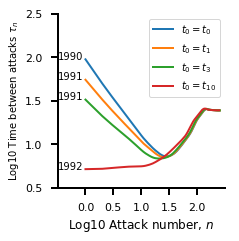

In [44]:
red_vs_blue_sensitivity(miami_u_data,variable="time_to_next_attacks",figname="./figures/S_red_blue_sensitivity.pdf")

/home/javiergb/Programs/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log10


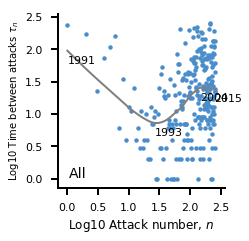

/home/javiergb/Programs/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


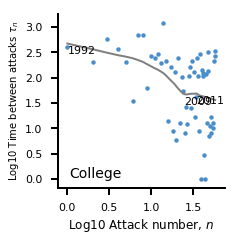

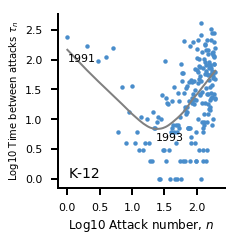

In [63]:
red_vs_blue(miami_u_data,type_attacks="All",variable="time_to_next_attacks",figname="./figures/1d_all.pdf")
red_vs_blue(miami_u_data,type_attacks="College",variable="time_to_next_attacks",figname="./figures/1f_coll.pdf")
red_vs_blue(miami_u_data,type_attacks="K-12",variable="time_to_next_attacks",figname="./figures/1e_k12.pdf")

Median event 1.0


/home/javiergb/Dropbox/Paper_SS/ss/helper_functions.py:135: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(True)
/home/javiergb/Programs/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/javiergb/Programs/anaconda3/lib/python3.5/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


Best chi-sqare value for powerlaw:  0.870516034383  Degree Freedom:  11 2.5089
['xmin = ', '1', 'Alpha = ', '2.5089']
Best chi-sqare value for powerlaw:  0.999608638025  Degree Freedom:  10 2.2812
['xmin = ', '2', 'Alpha = ', '2.2812']
Median event 4.0
Best chi-sqare value for powerlaw:  0.0  Degree Freedom:  10 1.5639
['xmin = ', '1', 'Alpha = ', '1.5639']
Best chi-sqare value for powerlaw:  0.0197790706792  Degree Freedom:  10 4.209
['xmin = ', '4', 'Alpha = ', '4.209']


/home/javiergb/Programs/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


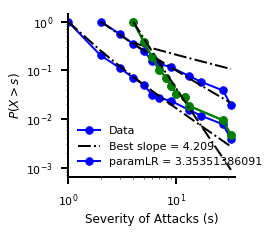

In [10]:
#Figure 1A
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(1,1,1)
        
for name,data,color in zip(["shultz_pl","usatoday_pl"],[miami_u_data,usatoday_data,],["blue","green"]):
    ax = plotCCDF(data,"number_victims",fit="powerlaw",normalize=False,color=color,ax=ax)
plt.xlabel('Severity of Attacks (s)',fontsize = 12)
plt.ylabel(r'$P(X>s)$',fontsize = 12)    
customaxis(ax,size=11,lw=2)
plt.legend()
plt.savefig("./figures/fig1a_pl.pdf", bbox_inches='tight' ,dpi=100)
plt.show()

Median event 18.0
Median event 4.0
Median event 12.0


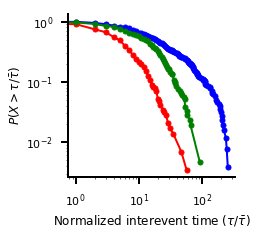

In [22]:
#Figure 1B
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(1,1,1)
plotCCDF(miami_u_data,"time_to_next_attacks",fit=None,normalize=False,color="b",ax=ax)
plotCCDF(everytown_u_data,"time_to_next_attacks",fit=None,normalize=False,ax=ax,color="r")
plotCCDF(usatoday_data,"time_to_next_attacks",fit=None,normalize=False,ax=ax,color="g")
plt.xlabel(r'Normalized interevent time ($\tau / \bar{\tau}$)',fontsize = 12)
plt.ylabel(r'$P(X>\tau / \bar{\tau})$',fontsize = 12)    
customaxis(ax,size=11,lw=2)

plt.savefig("./figures/fig1b.pdf", bbox_inches='tight' ,dpi=100)
plt.show()

Median event 18.0
Median event 4.0
Median event 12.0


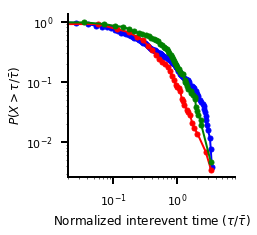

In [23]:
#Figure 1B
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(1,1,1)
plotCCDF(miami_u_data,"time_to_next_attacks",fit=None,normalize=True,color="b",ax=ax)
plotCCDF(everytown_u_data,"time_to_next_attacks",fit=None,normalize=True,ax=ax,color="r")
plotCCDF(usatoday_data,"time_to_next_attacks",fit=None,normalize=True,ax=ax,color="g")
plt.xlabel(r'Normalized interevent time ($\tau / \bar{\tau}$)',fontsize = 12)
plt.ylabel(r'$P(X>\tau / \bar{\tau})$',fontsize = 12)    
plt.xlim(2E-2,8)
customaxis(ax,size=11,lw=2)
plt.savefig("./figures/fig1b_inset.pdf", bbox_inches='tight' ,dpi=100)
plt.show()

In [27]:
miami_u_data["time_from_previous_attacks"].describe()

count    257.000000
mean      39.042023
std       52.022352
min        0.100000
25%        7.000000
50%       18.000000
75%       49.000000
max      256.000000
Name: time_from_previous_attacks, dtype: float64

/home/javiergb/Programs/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/javiergb/Programs/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/javiergb/Programs/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pan

(0.1, 3.0] False (0.42139372138825032, 0.77093376163579919)
(0.1, 3.0] True (0.22906623836420079, 0.57860627861174962)
(3.0, 7.0] False (0.46488637089104201, 0.80254135208765764)
(3.0, 7.0] True (0.19745864791234233, 0.53511362910895788)
(7.0, 11.0] False (0.65278830116585618, 0.94357830353192851)
(7.0, 11.0] True (0.056421696468071499, 0.34721169883414382)
(11.0, 18.0] False (0.5771634770217805, 0.90066213504198023)
(11.0, 18.0] True (0.099337864958019759, 0.4228365229782195)
(18.0, 27.0] False (0.64539944054973108, 0.93021211633369005)
(18.0, 27.0] True (0.069787883666309961, 0.35460055945026892)
(27.0, 49.0] False (0.6143334890033928, 0.92286448799893439)
(27.0, 49.0] True (0.077135512001065595, 0.3856665109966072)
(49.0, 88.56] False (0.68101018028956362, 0.94891130064391871)
(49.0, 88.56] True (0.051088699356081207, 0.31898981971043638)
(88.56, 256.0] False (0.77926459847703811, 0.99182186553934371)
(88.56, 256.0] True (0.0081781344606563118, 0.22073540152296189)


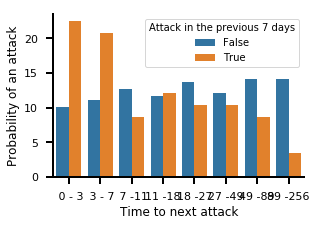

In [52]:
#Fig 1C
probability_attack(miami_u_data,"./figures/fig1c.pdf",9)


## Figure 2. self-exciting process

In [379]:
def createInputfile(folder_name,fname,rbin,tbin):
    st = """*______ DATA ______
* CATALOGUE FILE NAME
../../data/{}
* # COLUMN FOR (2) time (21 magnitude (3) latitude (4) longitude [NB: 1st column is "1" not "0"]
4 3 2 1
* ARE THE EPICENTRES REALLY IN (LAT LON) OR RATHER IN (X Y) FORMAT (1/0)?
1
* CORRECTION FOR DETECTION (0/1)? IF yes (1) THEN FOLLOW WITH NAME OF FILE CONTAINING THE CORRECTION VALUES
0
*______ DISCRETIZATION ______
* MAGNITUDE INTERVALS
0 100 1000
* TIME INTERVALS
{}
* DISTANCE INTERVALS (km if epicentres in lat/lon)
{}
*______ BACKGROUND ______
* BACKGROUND OPTIONS: (1) imposed rate (follow with rate) (2) random 2D Poisson (follow with surface)
* (3) random 2D Poisson with periodic boundaries (follow with square surface) (4) Poisson & spatial clustering
2 9000000.
*______ CONVERGENCE _______
* CONVERGENCE LEVEL
0.01
*______ OUTPUT _______
* SUFFIX FOR OUTPUT FILES
.temp
* SAVE mbin tbin rbin lambda_t lambda_s lambda0 w w0 (0/1 for each)?
1 1 1 1 1 1 1 1""".format(fname,tbin,rbin)

    with open("{}/input.temp".format(folder_name), "w") as f:
        f.write(st)
        
def create_baseline(fname,type_baseline,poisson=False):
    df = pd.read_csv("./data/us_cities/usCities.txt")
    cities_prob = df["Population"].values/np.sum(df["Population"].values)

    t = pd.read_csv("./data/{}".format(fname),sep=" ",header=None,names=["a","b","c","t"]).loc[:,"t"].values
    if poisson:
        t = np.cumsum(np.random.exponential(np.mean(np.diff(t)),len(t)))
    
    number_attacks = len(t)
    time_total = t[-1]
    ind = np.random.choice(np.arange(len(cities_prob)),number_attacks,p=cities_prob)

    with open("./data/{}_{}_{}.dat".format(type_baseline,poisson,fname),"w+") as f:    
        for i in range(number_attacks):
            if type_baseline == "random":
                l = np.random.uniform(27.5,46.1)#df["Latitude"].values.min(),df["Latitude"].values.max())
                lo = np.random.uniform(-122.3,-74)#df["Longitude"].values.min(),df["Longitude"].values.max())
            elif type_baseline == "pop":
                l = df["Latitude"].values[ind[i]]
                lo = df["Longitude"].values[ind[i]] 

            f.write("{0} {1} {2} {3}\n".format(l,lo,1,int(t[i])))


In [380]:
def keep_stats(folder_name,fname):    
    surface = 9000000.
    mbin = np.array([0,100,1000])
    lambda_t = np.loadtxt("./{}/lambda_t.temp".format(folder_name))
    lambda_r = np.loadtxt("./{}/lambda_r.temp".format(folder_name))
    lambda0 = np.loadtxt("./{}/lambda0.temp".format(folder_name))
    w = np.loadtxt("./{}/w.temp".format(folder_name))
    np.fill_diagonal(w,np.loadtxt("./{}/w0.temp".format(folder_name)))
    w0 = np.loadtxt("./{}/w0.temp".format(folder_name))
    with open("./{}/misd2_stats.csv".format(folder_name),"a+") as f:
        f.write("{}\n".format(np.sum(np.diag(w))/np.shape(w)[0]))

    print(np.sum(np.diag(w))/np.shape(w)[0])
    magnitude = np.sum(lambda_r,1)*np.sum(lambda_t,1)
    tEnd = np.loadtxt("./data/"+fname)[-1,-1]
    print(lambda0)
    print(lambda0*surface)
    print(lambda0*tEnd)
    print(np.sum(w0)/tEnd)


    with open("./{}/a.txt".format(folder_name),"a+") as f:
        saveLine = [str(_) for _ in np.sum(lambda_r,0)]
        f.write("{}\n".format(",".join(saveLine)))
    with open("./{}/a_time.txt".format(folder_name),"a+") as f:
        saveLine = [str(_) for _ in np.sum(lambda_t,0)]
        f.write("{}\n".format(",".join(saveLine)))
    with open("./{}/a_lambda0.txt".format(folder_name),"a+") as f:
        f.write("{}\n".format(lambda0))
    with open("./{}/a_tEnd.txt".format(folder_name),"a+") as f:
        f.write("{}\n".format(tEnd))


def distanceSt(folder_name,fname):
    #Distance vs Pairs
    print(folder_name)
    w = np.loadtxt("./{}/w.temp".format(folder_name))
    print(w.shape)
    w0 = np.loadtxt("./{}/w0.temp".format(folder_name))
    att = np.loadtxt("./data/"+fname)[:,-2]
    lenAtt = len(att)
    w_back = np.zeros((lenAtt,lenAtt))
    for i in range(lenAtt):
        for j in range(i+1,lenAtt):
            w_back[i,j] = w0[i]*w0[j]

    all = np.loadtxt("./data/"+fname)
    lat = all[:,0]
    lng = all[:,1]
    pops = all[:,2]
    times = all[:,3]
    lenAtt = len(lng)

    R = 6370.
    lat *= np.pi/180.
    lng *= np.pi/180.
    x = R*np.cos(lat)*np.cos(lng)
    y = R*np.cos(lat)*np.sin(lng)
    z = R*np.sin(lng)

    timesDist = np.zeros((lenAtt,lenAtt))+np.inf
    for i in range(lenAtt):
        print(i)
        for j in range(i+1,lenAtt):
            dist = times[j]-times[i]
            timesDist[i,j] = dist
    #r[r == 0] = np.inf

    r = np.zeros((lenAtt,lenAtt))+np.inf
    for i in range(lenAtt):
        print(i)
        for j in range(i+1,lenAtt):
            dist = np.sqrt((x[i]-x[j])**2 + (y[i]-y[j])**2 + (z[i]-z[j])**2)
            r[i,j] = dist
    #r[r == 0] = np.inf
    np.savetxt("./{}/r.temp".format(folder_name),r)
    np.savetxt("./{}/t.temp".format(folder_name),timesDist)

    t = []
    t_ind = []
    t_back = []

    t2 = []
    t_ind2 = []
    t_back2 = []

    radios = np.logspace(0,4,100)
    timesBins = np.logspace(0,4,100)

    #ones = np.ones(np.shape(pop))
    for radio in radios:
        if fname == "./cities/np_usCities.txt":
            t.append(np.sum(r<=radio))
        else:
            t.append(np.sum(r<=radio))
            t_ind.append((np.sum(w[r<=radio])))
            t_back.append(np.sum(w_back[r<=radio]))
    print(t)
    for timeBin in timesBins:
        if fname == "./cities/np_usCities.txt":
            t2.append(np.sum(timesDist<=timeBin))
        else:
            t2.append(np.sum(timesDist<=timeBin))
            t_ind2.append((np.sum(w[timesDist<=timeBin])))
            t_back2.append(np.sum(w_back[timesDist<=timeBin]))
    print(r)
  
    t_ind = np.array(t_ind)/lenAtt#/(lenAtt*(lenAtt-1)/2.)
    t = np.array(t,dtype="float")/t[-5]#/(lenAtt*(lenAtt-1)/2.)
    t_back = np.array(t_back)/(lenAtt*(lenAtt-1)/2.)

    t_ind2 = np.array(t_ind2)/lenAtt#/(lenAtt*(lenAtt-1)/2.)
    t2 = np.array(t2,dtype="float")/t2[-5]#/(lenAtt*(lenAtt-1)/2.)
    t_back2 = np.array(t_back2)/(lenAtt*(lenAtt-1)/2.)

       
    with open("./{}/a_t.txt".format(folder_name),"a+") as f:
        saveLine = [str(_) for _ in t]
        f.write("{}\n".format(",".join(saveLine)))
    with open("./{}/a_tind.txt".format(folder_name),"a+") as f:
        saveLine = [str(_) for _ in t_ind]
        f.write("{}\n".format(",".join(saveLine)))
    with open("./{}/a_tback.txt".format(folder_name),"a+") as f:
        saveLine = [str(_) for _ in t_back]
        f.write("{}\n".format(",".join(saveLine)))

    with open("./{}/a_t2.txt".format(folder_name),"a+") as f:
        saveLine = [str(_) for _ in t2]
        f.write("{}\n".format(",".join(saveLine)))
    with open("./{}/a_tind2.txt".format(folder_name),"a+") as f:
        saveLine = [str(_) for _ in t_ind2]
        f.write("{}\n".format(",".join(saveLine)))
    with open("./{}/a_tback2.txt".format(folder_name),"a+") as f:
        saveLine = [str(_) for _ in t_back2]
        f.write("{}\n".format(",".join(saveLine)))



In [381]:
def run_null_model(fname,type_baseline=None,poisson=False):
    """
    type_baseline: None, random, pop
    """
    
    if type_baseline is None:
        folder_name = "self_excitation/{}".format(fname.split(".")[0])
    else:
        folder_name = "self_excitation/{}_{}_{}".format(type_baseline,poisson,fname.split(".")[0])
        
        
    print(folder_name)
    !mkdir "$folder_name"
    misd = "{}/misd".format(folder_name)
    misdc = "{}/misd.c".format(folder_name)
    copyfile("self_excitation/misd", misd)
    copyfile("self_excitation/misd.c", "{}/misd.c".format(folder_name))
    !chmod +x  "$misd"
    !chmod +x  "$misdc"

    rb_merged = " ".join([str(_) for _ in rbin])
    tb_merged = " ".join([str(_) for _ in tbin])
    if type_baseline is None:
        createInputfile(folder_name,fname,rb_merged,tb_merged)
    else:
        createInputfile(folder_name,"{}_{}_{}.dat".format(type_baseline,poisson,fname),rb_merged,tb_merged)
    
    
    if type_baseline is not None:
        try:
            with open(folder_name+"/misd2_stats.csv") as f:
                lines = len(f.readlines())
        except:
            lines = 0
        reps = 10000 - lines
    else:
        reps = 1
        
    for i in range(reps):
        #null_models
        if type_baseline is not None:
            create_baseline(fname,type_baseline,poisson)
            
        #run code
        !cd "$folder_name" &&  ./misd input.temp
        
        
        
        #append to statistics
        keep_stats(folder_name,fname)
        distanceSt(folder_name,fname)
        
    
def multiproc(x):
    print(x)
    fname,type_baseline,poisson = x
    run_null_model(fname,type_baseline,poisson)

In [382]:
tbin = np.array([0, 1.1, 3.1, 10.1, 30.1, 100.1,  1000.1, 10000.1])
rbin = np.array([0,1,3, 10,30, 100, 300, 1000,3000, 10000])

In [ ]:
%%capture
models = ["usatoday_self_excitation.tsv","alyssa_u_self_excitation.tsv","everytown_u_self_excitation.tsv"] 
null_models = [(model,tb,poisson) for model in models for tb in ["random","pop"] for poisson in [False,True]]

for model in models:
    run_null_model(model,type_baseline=None)

with Pool() as pool:
    pool.map(multiproc,null_models);




self_excitation/usatoday_self_excitation 2.878211066
self_excitation/everytown_u_self_excitation 3.369395429399999
self_excitation/alyssa_u_self_excitation 1.1784357031
self_excitation/pop_True_alyssa_u_self_excitation 0.000507427925980256
self_excitation/random_False_alyssa_u_self_excitation 3.5662680488065674e-06
self_excitation/random_True_alyssa_u_self_excitation 2.770216099691486e-06
self_excitation/pop_False_alyssa_u_self_excitation 0.0006485779655605298
self_excitation/pop_True_everytown_u_self_excitation 0.0006586952933572358
self_excitation/pop_False_everytown_u_self_excitation 0.0006556859555530675
self_excitation/pop_True_usatoday_self_excitation 0.0004527177923042274
self_excitation/pop_False_usatoday_self_excitation 0.0004514028546130778


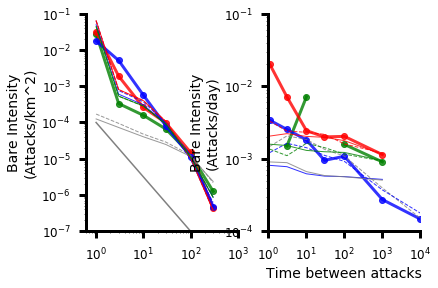

In [397]:
def plot_r_t_hawkes(folder_name,ax,ax2):
    lambda_r = pd.read_csv("./{}/a.txt".format(folder_name),header=None,index_col=None)
    lambda_t = pd.read_csv("./{}/a_time.txt".format(folder_name),header=None,index_col=None)
    rs = np.array(rbin)
    ts = np.array(tbin)
    rs[0] = .1
    ts[0] = 1.
    lw = 1
    if "random" in folder_name:
        typ = "-."
    if "False" in folder_name:
        typ = "--"
    elif "True" in folder_name:
        typ = "-"
    else:
        lw = 3
        typ = "o-"
    
    if "random" in folder_name:
        color = "gray"  
    elif "alyssa" in folder_name:
        color = "b"
    elif "usa" in folder_name:
        color = "g"
    else:
        color = "r"
    x = np.array(rs[1:],dtype=float)
    y = np.nanmean(lambda_r,0)
    
    x[y<1E-7] = np.NaN
    y[y<1E-7] = np.NaN    
    ax.plot(x,y,typ,label="all",linewidth=lw,color=color,alpha=0.8)
    
    
    x = np.array(ts[1:],dtype=float)
    y = np.nanmean(lambda_t,0)
    x[y<1E-4] = np.NaN
    y[y<1E-4] = np.NaN       
    ax2.plot(x,y,typ,label="all",linewidth=lw,color=color,alpha=0.8)

    print(folder_name,np.sum(np.mean(lambda_r,0))/len(lambda_r)*100)
        

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,2,1)    
ax2 = fig.add_subplot(1,2,2)
customaxis(ax)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim([0.6,1E3])
ax.set_ylim([1E-7,1E-1])
ax2.set_xlabel("Distance between attacks",fontsize=14)    
ax.set_ylabel("Bare Intensity\n(Attacks/km^2)",fontsize=14)
customaxis(ax2)
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_xlim([1,1E4])
ax2.set_ylim([1E-4,1E-1])
ax2.set_ylabel("Bare Intensity\n(Attacks/day)",fontsize=14)
ax2.set_xlabel("Time between attacks",fontsize=14)    

ax.plot([1E0,1E2],[1E-4,1E-7],color="gray")
#ax2.plot([1E0,1E2],[1E-1,1E-3],color="gray")
ax.set_xticks(np.logspace(0, 3, 4))
ax2.set_xticks(np.logspace(0, 4, 5))    

    
models = ["usatoday_self_excitation.tsv","alyssa_u_self_excitation.tsv","everytown_u_self_excitation.tsv"] 
null_models = [(model,tb,poisson) for model in models for tb in ["random","pop"] for poisson in [False,True]]

for model in ['usatoday_self_excitation.tsv','everytown_u_self_excitation.tsv','alyssa_u_self_excitation.tsv',
      'pop_True_alyssa_u_self_excitation.tsv.dat','random_False_alyssa_u_self_excitation.tsv.dat','random_True_alyssa_u_self_excitation.tsv.dat',
     'pop_False_alyssa_u_self_excitation.tsv.dat','pop_True_everytown_u_self_excitation.tsv.dat',
     'pop_False_everytown_u_self_excitation.tsv.dat','pop_True_usatoday_self_excitation.tsv.dat',
     'pop_False_usatoday_self_excitation.tsv.dat']:
    folder_name = "self_excitation/"+model.split(".")[0]
    plot_r_t_hawkes(folder_name,ax,ax2)

plt.savefig("./figures/fighawkes.pdf")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     177.9
Date:                Wed, 30 May 2018   Prob (F-statistic):           4.24e-05
Time:                        16:06:53   Log-Likelihood:                 8.0087
No. Observations:                   7   AIC:                            -12.02
Df Residuals:                       5   BIC:                            -12.13
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.4199      0.057    -42.368      0.0

/home/shared/anaconda3/lib/python3.5/site-packages/statsmodels/stats/stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  "samples were given." % int(n), ValueWarning)


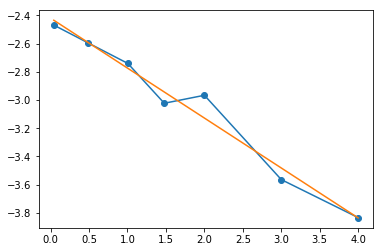

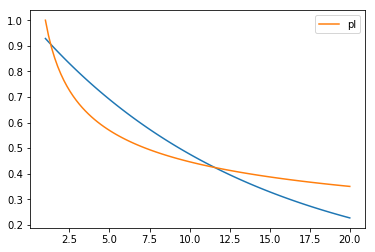

In [432]:
import  statsmodels.api as sm
x = np.log10(tbin[1:])
y = np.log10(np.loadtxt("self_excitation/alyssa_u_self_excitation/a_time.txt",delimiter=",")[1,:])
X = sm.add_constant(x)
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())



slope, intercept, r_value, p_value, std_err = linregress(x,y)
print(slope, intercept, r_value, p_value, std_err)
plt.plot(x,y,"o-")
plt.plot(x,x*slope+intercept)

x = np.linspace(1,20,100)
plt.show()

plt.plot(x,np.exp(-x/13.5))
plt.plot(x,1/x**0.35,label="pl")
plt.legend()

In [375]:
def create_pop_random_long(type_baseline,number_attacks=1000):
    df = pd.read_csv("./data/us_cities/usCities.txt")
    cities_prob = df["Population"].values/np.sum(df["Population"].values)
    ind = np.random.choice(np.arange(len(cities_prob)),number_attacks,p=cities_prob)

    with open("./data/{}.dat".format(type_baseline),"w+") as f:    
        for i in range(number_attacks):
            if type_baseline == "random":
                l = np.random.uniform(27.5,46.1)#df["Latitude"].values.min(),df["Latitude"].values.max())
                lo = np.random.uniform(-122.3,-74)#df["Longitude"].values.min(),df["Longitude"].values.max())
            elif type_baseline == "pop":
                l = df["Latitude"].values[ind[i]]
                lo = df["Longitude"].values[ind[i]] 

            f.write("{0} {1}\n".format(l,lo))

In [ ]:
models = ["usatoday_self_excitation.tsv","alyssa_u_self_excitation.tsv","everytown_u_self_excitation.tsv"] 
null_models = ["{}_{}_{}.dat".format(tb,poisson,model) for model in models for tb in ["random","pop"] for poisson in [False,True]]

create_pop_random_long("random",number_attacks=1000)
create_pop_random_long("pop",number_attacks=1000)
import geopy.distance
ax = plt.figure(figsize=(3,3)).add_subplot(111)



for model in ['everytown_u_self_excitation.tsv','alyssa_u_self_excitation.tsv',
              'random.dat','pop.dat']:
    print(model)
    df = pd.read_csv("./data/{}".format(model),sep=" ",header=None)
    coords = []
    for i,row in df.iterrows():
        coords.append((np.round(row[0],2),np.round(row[1],2)))
    x = []
    for i in range(len(coords)):
        for j in range(i+1,len(coords)):
            x.append(geopy.distance.vincenty(coords[i], coords[j]).km)
            
    x = np.sort(x)
    x = x[np.isfinite(x)]
    x[x<10] = 1
    a = []
    for i in np.logspace(0,4,100):
        a.append(np.sum(x<i))
    plt.plot(np.logspace(0,4,100),np.array(a)/len(x),".",label=model)
    
plt.legend()
plt.xscale("log")
plt.ylim(1E-3,1)
plt.xlim(2,1E4)
plt.xlabel("Distance")
plt.ylabel("Fraction of attack pairs")
plt.yscale("log")
customaxis(ax, c_right='none', c_top='none',lw=2, size=10, pad=8)
plt.savefig("./figures/scaling.pdf")

## Figure 3. early vs late
Not updated since no info on suicide or tweets in the updated data

In [59]:
def early_vs_late(data,ax=None,variable="time_from_previous_attacks"):
    sizeEvent = data[variable].values
    sizeEvent = np.round(sizeEvent[np.isfinite(sizeEvent)],0)
    data = data.dropna(subset=["time_from_previous_attacks"]).reset_index()
    del data["index"]
    
    x = np.log10(np.arange(1,len(sizeEvent)+1))
    y = np.log10(sizeEvent)
    a = lowess(y,x,frac = 0.66,delta=0.0)

    data["log_time_from_previous_attacks"] = y
    data = data.iloc[1:len(a)+1]

    data["log_theo_time_from_previous_attacks"] = a[:,1]
    data["log_diff_times"] = data["log_time_from_previous_attacks"] - data["log_theo_time_from_previous_attacks"]
    if ax is None:
        fig = figure(figsize=(4.5,3))
        ax = fig.add_subplot(1,1,1)
    dist_name = 'norm'
    log_diff_times = data["log_diff_times"].values
    log_diff_times = log_diff_times[np.isfinite(log_diff_times)]
    print(np.mean(log_diff_times),np.std(log_diff_times))
    h = 10
    ax.hist(log_diff_times,bins=np.linspace(-1.5,1.5,h),normed=1,edgecolor='white',facecolor='gray',alpha=0.5)
    dist = getattr(scipy.stats, dist_name)
        
    param = dist.fit(log_diff_times)
    x_pl = np.linspace(-1.5,1.5,100)
    pdf_fitted = dist.pdf(x_pl, *param[:-2], loc=param[-2], scale=param[-1])
    ax.plot(x_pl, pdf_fitted, linewidth=3,alpha=0.5,label='Normal Fit')
    ax.legend()
    ax.set_xlabel(r"$\sum{\epsilon}$",fontsize=12)
    ax.set_ylabel("Probability",fontsize=12)
    customaxis(ax, c_right='none', c_top='none',lw=2, size=12, pad=8)
    data["Type"] = "Rest"
    ax.set_xticks(np.arange(min(x_pl),max(x_pl),0.5))
    ax.set_yticks(np.arange(0,max(pdf_fitted),0.1))
    ax.vlines([(np.mean(log_diff_times) - np.std(log_diff_times)),(np.mean(log_diff_times) + np.std(log_diff_times))],0,0.5)
    print( (np.mean(log_diff_times) + np.std(log_diff_times)))
    print( )
    data.loc[data["log_diff_times"] < (np.mean(log_diff_times) - 1*np.std(log_diff_times)),"Type"] = "Early"
    data.loc[data["log_diff_times"] > (np.mean(log_diff_times) + 1*np.std(log_diff_times)),"Type"] = "Late"
    
    return data

In [60]:
def get_tweet_list(time=None):
    tweets = pd.read_csv("./data/all_tweets_formatted.tsv",sep="\t",parse_dates=["date"])
    tweets = tweets.sort_values(by="date")
    if time: #filter by year
        tweets = tweets.loc[tweets["date"]>time,:]
    datesFinal, tweetsAll, tweetsSS, tweetsMS, tweetsMM, tweetsS = tweets["date"].values,tweets["all"].values,tweets["school_shooting"].values,tweets["mass_shooting"].values,tweets["mass_murder"].values,tweets["shooting"].values
    return [datesFinal,tweetsS,tweetsSS,tweetsAll,tweetsMS,tweetsMM]

/home/shared/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10


-0.0154838606213 0.536683593525
0.521199732904



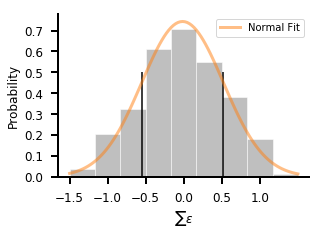

In [72]:
#this is based on the updated data
fig = figure(figsize=(4.5,3))
ax = fig.add_subplot(1,1,1)
miami_u_data_early_late = early_vs_late(miami_u_data,ax=ax)
plt.savefig("./data/early_late.pdf")

In [66]:
tweets = pd.read_csv("./data/all_tweets_formatted.tsv",sep="\t",parse_dates=["date"])

In [144]:
def tweets_before_attack(datas,days=5):
    #datas = list of dataframes
    def get_shootings_before(date,date_before,days):
        result = tweets.loc[(tweets["date"]>=date_before)&(tweets["date"]<date),"school_shooting"]
        if len(result) < 5:
            return np.NaN
        else:
            return result.sum()
    for data in datas:
        data["date_before"] = data["date"]-pd.DateOffset(days)
        data["tweets_before"] = data[["date","date_before"]].apply(lambda x: get_shootings_before(x[0],x[1],days),axis=1)
        data = data.loc[data["tweets_before"]>=0]
        sns.barplot(x="Type",y="tweets_before",data=data,ci=90)
        return data

,date,state,school,type_school,death,suicide,number_victims,lat,lon,time_from_previous_attacks,time_to_next_attacks,log_time_from_previous_attacks,log_theo_time_from_previous_attacks,log_diff_times,Type,date_before,tweets_before
228,2014-04-21,IN,NaN,K-12,1,NaN,1,41.528369,-87.423650,10.0,32.0,1.000000,1.390117,-0.390117,Rest,2014-04-16,3851.0
229,2014-05-23,CA,NaN,College,1,NaN,6,34.420831,-119.698190,32.0,13.0,1.505150,1.390064,0.115086,Rest,2014-05-18,2420.0
230,2014-06-05,WA,NaN,College,1,NaN,1,47.606210,-122.332071,13.0,5.0,1.113943,1.390013,-0.276070,Rest,2014-05-31,2662.0
231,2014-06-10,OR,NaN,K-12,1,NaN,1,45.539286,-122.387313,5.0,136.0,0.698970,1.389965,-0.690995,Early,2014-06-05,4928.0
232,2014-10-24,WA,NaN,K-12,1,NaN,4,48.051764,-122.177082,136.0,27.0,2.133539,1.389920,0.743618,Late,2014-10-19,3704.0


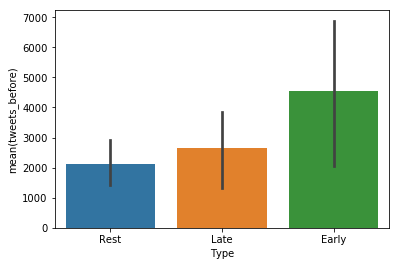

In [145]:
tweets_before_attack([miami_u_data_early_late]).tail()

# Learning

In [209]:
def get_slope(days_betw_attacks):
    x = np.log10(np.arange(1,len(days_betw_attacks)+1))
    y = np.log10((days_betw_attacks))
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    return [slope,intercept,r_value]


In [455]:
def plot_learning(th=0):
    fig = figure(figsize=(5.5,3))
    ax = fig.add_subplot(1,1,1)
    colors = ["b","r","g"]
    for bd in [miami_u_data,everytown_u_data,usatoday_data]:
        color=colors.pop(0)
        tau1 = []
        slopes = []

        for state,data in bd.groupby("state"):
            days_attack = get_time_between_attacks(data)[th:]
            if len(days_attack) > 4:
                tau1.append(np.log10(days_attack)[0])
                [slope,intercept,r_value] = get_slope(days_attack)
                slopes.append(-slope)


        plt.scatter(tau1,slopes,s=15,color=color)

        slope2b, interceptb, r_valueb, p_value, std_err = linregress(tau1,slopes)
        ax.plot(tau1,interceptb+slope2b*np.array(tau1),color,linewidth=2,alpha=0.8)
    ax.set_xlabel(r'log $\tau_{1}$',fontsize=14)
    ax.set_ylabel(r'Learning rate b',fontsize=14)  
    ax.set_xticks(np.arange(0.5,3.5,0.5))
    ax.set_yticks(np.arange(-2.5,2.8,1))
    
    plt.ylim(-3,3)
    customaxis(ax, c_right='none', c_top='none',lw=2, size=12, pad=8)
    plt.savefig("./figures/learning.pdf")

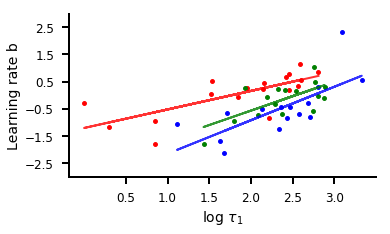

In [456]:
plot_learning(0)

# Supplementary

[ 0.15063429  0.09875633  0.1159961   0.08758445  0.14248793  0.00051512
 -0.07194001 -0.06442614  0.01556179 -0.02225665 -0.02507843]
[ 0.08648805  0.24838313 -0.02125092  0.06509376  0.03678933  0.02083589
 -0.02164039  0.08980631 -0.04472283  0.07605974  0.01033121]
[ 0.09047613  0.13998493 -0.09978506 -0.06247489 -0.08132058 -0.13404905
  0.00530828 -0.05391608 -0.04391466  0.01264448 -0.04244241]


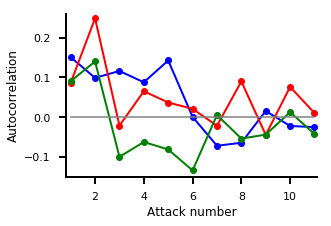

In [297]:
def correlation(wTimesList,plot=True):
    colors = ["b","r","g"]
    fig = plt.figure(figsize=(4.5,3))
    ax = fig.add_subplot(1,1,1)
    for i,wTimes in enumerate(wTimesList):
        wTimes = wTimes[np.isfinite(wTimes)]
        wTimes = (wTimes - np.mean(wTimes))/np.std(wTimes)
        d= np.correlate(wTimes,wTimes,"same")/len(wTimes)
        d =  d[int(len(d)/2):][1:12]
        print(d)
        ax.plot(range(1,12),d,"o-",color=colors[i],linewidth=2)
    
    ax.plot(range(1,12),[0]*11,color="gray")
    plt.ylim((-0.15,0.26))
    plt.xlim(0.8,11.1,2)
    plt.ylabel("Autocorrelation",fontsize=12)
    plt.xlabel("Attack number",fontsize=12)
    customaxis(ax, c_right='none', c_top='none',lw=2, size=11, pad=8)
    plt.savefig('./figures/correlation.pdf', bbox_inches='tight' ,dpi=100)

correlation([bd["time_to_next_attacks"].values for bd in [miami_u_data,everytown_u_data,usatoday_data]])

51.9210424999 1.329875812 39.0420233463 0.141585148145
7.42755155944 1.14900032153 6.46435986159 0.069334713464
15.690588691 0.962696380194 16.2985849057 -0.0190063120216


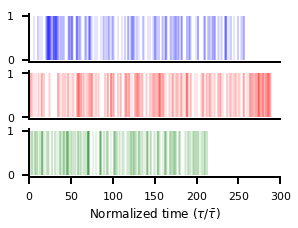

In [422]:
def burstiness(wTimesList,plot=True):
    colors = ["b","r","g"]
    fig = plt.figure(figsize=(4.5,3))
    
    for i,wTimes in enumerate(wTimesList):
        ax = fig.add_subplot(3,1,i+1)
        wTimes = wTimes[np.isfinite(wTimes)]
        print(np.std(wTimes),np.std(wTimes)/np.mean(wTimes),np.mean(wTimes),
              (np.std(wTimes)/np.mean(wTimes)-1)/(np.std(wTimes)/np.mean(wTimes)+1))
        wTimes = wTimes/np.mean(wTimes)
        wTimes = np.cumsum(wTimes)
        ax.vlines(wTimes,0,1,color=colors[i],lw=0.2)
        ax.set_xlim(0,300)
        if i < 2:
            customaxis(ax, c_right='none', c_top='none',lw=2, size=11, pad=8)
            plt.tick_params(
            axis='both',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False,
            labelright=False) # labels along the bottom edge are off        
        else:
            customaxis(ax, c_right='none', c_top='none',lw=2, size=11, pad=8)
    plt.xlabel(r"Normalized time ($\tau/\bar{\tau}$)",fontsize=12)
    customaxis(ax, c_right='none', c_top='none',lw=2, size=11, pad=8)
    plt.savefig('./figures/burstiness.pdf', bbox_inches='tight' ,dpi=100)

burstiness([bd["time_to_next_attacks"].values for bd in [miami_u_data,everytown_u_data,usatoday_data]])

In [424]:
miami_u_data["time_to_next_attacks"].mean()

39.04202334630351

In [423]:
everytown_u_data["time_to_next_attacks"].mean()

6.464359861591692

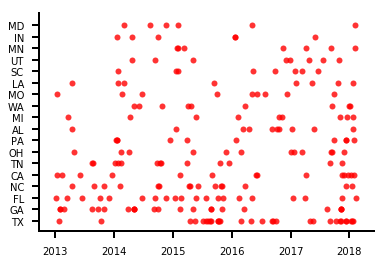

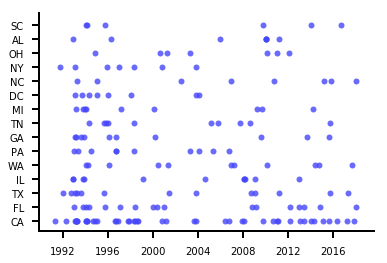

In [374]:
def plot_scatter(data,color=(70/255,70/255,250/255,0.8),figname=None):
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(111)
    i = 0
    data["all_in_state"] = data.groupby("state")["date"].transform(len)
    data = data.sort_values(by="all_in_state",ascending=False)
    states = []
    for g,d2 in data.groupby("state",sort=False):
        if len(d2)<=5:
            continue
        i += 1
        states.append(g)
        ax.scatter(d2["date"].values,[i]*len(d2),color=color,alpha=0.8,lw=0)
    plt.yticks(np.arange(1,1+len(states)),states)
    customaxis(ax, c_right='none', c_top='none',lw=2, size=10, pad=8)
    if figname:
        plt.savefig(figname)
    
plot_scatter(everytown_u_data,"red","./figures/everytown_attacks.pdf")
plot_scatter(miami_u_data,figname="./figures/miami_u_attacks.pdf")

In [56]:
print(np.mean(x),np.std(x))
indexLate = np.nonzero(x<(np.mean(x)-1.*np.std(x)))[0]+1
indexEarly = np.nonzero(x>=(np.mean(x)+1.*np.std(x)))[0]+1
indexEarly = np.array(indexEarly,dtype="int")
indexLate = np.array(indexLate,dtype="int")
indLate = len(indexLate)
indEarly = len(indexEarly)


fig = figure(1, figsize=(9,6))
ax1 = fig.add_subplot(2,1,1)
[datesFinal,tweetsS,tweetsSS,tweetsAll,tweetsMS,tweetsMM] = studyTweets_v2(time=2009)

tweetsFinal = tweetsSS/tweetsAll
[datesFinal,tweetsFinal] = zip(*[(date,tweets)  for (date,tweets) in zip(datesFinal,tweetsFinal) if date>ddd[0]])
ax1.plot(datesFinal,1E6*np.asarray(tweetsFinal),'-',marker='.',linewidth=2,color='red',alpha=0.8)


ax1.set_ylabel('Number of tweets containing \n\"school shooting\" per million',fontsize=11)
ax1.set_ylim([0,350])
ax2 = ax1.twinx()

tweetsBeforeAttackEarly = np.zeros(indEarly)
tweetsBeforeAttackLate = np.zeros(indLate)
tweetsNotBeforeAttack = np.zeros(len(ddd))

sizeBeforeAttackEarly = np.zeros(indEarly)
sizeBeforeAttackLate = np.zeros(indLate)
sizeNotBeforeAttack = np.zeros(len(ddd))

i = -1
for dateX in ddd:
    i += 1
    ax2.vlines(dateX,0,sizeEvent[i],color = 'gray',linewidth=2)
    tweetsBefore = [tweets for (date,tweets) in zip(datesFinal,tweetsFinal) if date<dateX][-5:]
    if len(tweetsBefore) == 0:
        tweetsNotBeforeAttack[i] = np.NaN
    else:
        tweetsNotBeforeAttack[i] = np.max(tweetsBefore)
    sizeNotBeforeAttack[i] = sizeEvent2[i]



i = -1
print(indexEarly)
for element in indexEarly:
    #print ddd[element], element

    i += 1
    ax2.vlines(ddd[element],0,sizeEvent[element],color = (73./256, 142./256, 204./256),linewidth=3)
    tweetsBefore = [tweets for (date,tweets) in zip(datesFinal,tweetsFinal) if date<ddd[element]][-5:]

    tweetsBeforeAttackEarly[i] = np.max(tweetsBefore)
    sizeBeforeAttackEarly[i] = sizeEvent2[element]


print(indexLate)
i = -1
for element in indexLate:
    i += 1
    ax2.vlines(ddd[element],0,sizeEvent[element],color = 'orange',linewidth=3)
    tweetsBefore = [tweets for (date,tweets) in zip(datesFinal,tweetsFinal) if date<ddd[element]][-5:]

    tweetsBeforeAttackLate[i] = np.max(tweetsBefore)
    sizeBeforeAttackLate[i] = sizeEvent2[element]

print "sizes"
print sizeBeforeAttackLate
print sizeBeforeAttackEarly


ax2.set_ylabel('Size of Attack',fontsize=11)
ax1.set_xlabel('Time',fontsize=11)
customaxis(ax2, c_right='k', c_top='none',lw=2, size=10, pad=8)
customaxis(ax1, c_right='k', c_top='none',lw=2, size=10, pad=8)

ax2.set_ylim([0,4])
#ax1.set_xlim([datetime.datetime(2012,11,30),datetime.datetime(2013,3,30)])
#ax2.set_xlim([datetime.datetime(2012,11,30),datetime.datetime(2013,3,30)])
plt.clf()
ax5 = fig.add_subplot(2,1,2)
tweetsNotBeforeAttack *= 1E6
tweetsBeforeAttackLate *= 1E6
tweetsBeforeAttackEarly *= 1E6

print [np.median(tweetsNotBeforeAttack[~np.isnan(tweetsNotBeforeAttack)]),np.median(tweetsBeforeAttackEarly),
                   np.median(tweetsBeforeAttackLate)]
print [np.mean(sizeNotBeforeAttack[~np.isnan(sizeNotBeforeAttack)]),np.mean(sizeBeforeAttackEarly),np.mean(sizeBeforeAttackLate)]
print sizeBeforeAttackEarly
print sizeBeforeAttackLate
color = ['gray',(73./256, 142./256, 204./256),'orange']
width = 0.4
ax5.bar([1,1.5,2],[np.median(tweetsNotBeforeAttack[~np.isnan(tweetsNotBeforeAttack)]),np.median(tweetsBeforeAttackEarly),
                   np.median(tweetsBeforeAttackLate)],width=width,color=color)
                    #yerr = [np.std(tweetsNotBeforeAttack[~np.isnan(tweetsNotBeforeAttack)]),np.std(tweetsBeforeAttackEarly)
                    #    ,np.std(tweetsBeforeAttackLate)], width=width,color=color)
ax5.set_ylabel('Median number of tweets in the \n5 days previous to the attack')


ax6 = ax5.twinx()
color = ['gray',(73./256, 142./256, 204./256),'orange']
ax6.bar([3,3.5,4],[np.mean(sizeNotBeforeAttack[~np.isnan(sizeNotBeforeAttack)]),np.mean(sizeBeforeAttackEarly),np.mean(sizeBeforeAttackLate)],width=width,color=color)
        #yerr=[np.std(sizeNotBeforeAttack[~np.isnan(sizeNotBeforeAttack)]),np.std(sizeBeforeAttackEarly),np.std(sizeBeforeAttackLate)],width=width,color=color)
if fname == 'everytown.csv':
    ax6.set_ylabel('Average suicide rate')
else:
    ax6.set_ylabel('Average casualty number')

plt.xticks(np.asarray([1,1.5,2,3,3.5,4])+0.2,["All","Early","Late","All","Early","Late"])
customaxis(ax6, c_right='k', c_top='none',lw=2, size=10, pad=8)
customaxis(ax5, c_right='k', c_top='none',lw=2, size=10, pad=8)
savefig(fname+'StimelineOutliers.pdf', bbox_inches='tight' ,dpi=10)
show()

SyntaxError: Missing parentheses in call to 'print' (<ipython-input-56-e10d660bf632>, line 67)

In [112]:
miami_data["days_next"] = np.concatenate([daysBetweenAttacks,[0]])

In [113]:
miami_data["cut_victims"] = pd.cut(miami_data["number_victims"],bins=[0,1.1,2.1,3.1,7.1,100])

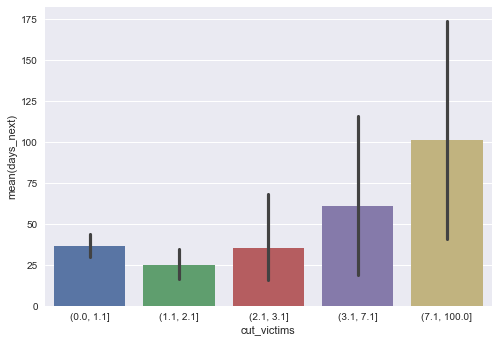

In [116]:
sns.barplot("cut_victims","days_next",data=miami_data,estimator=np.mean)

In [109]:
everytown_data.groupby("cut_victims").median()

,death,suicide,number_victims,days_next
cut_victims,,,,
"(-1.0, 0.1]",0.0,0.0,0.0,4.0
"(0.1, 1.1]",1.0,0.0,1.0,5.0
"(1.1, 2.1]",1.0,0.0,2.0,5.0
"(2.1, 3.1]",1.0,0.0,3.0,0.1
"(3.1, 7.1]",1.0,0.5,5.0,31.5
"(7.1, 100.0]",NaN,NaN,NaN,NaN


In [11]:
def regetDataDaysMiami_v2(fname,state=0,type=0,time=0):
    
    f1 = open(fname)
    #Add data to array
    x = 1991
    z = datetime(x,1,1)
    j = []
    countV = np.zeros(25)
    countV2 = np.zeros(25)
    count = 0
    sizeEvent = []
    sizeEvent2 = []
    for line in f1:
        a =line.split(';')
        dat = datetime.strptime(a[0],"%m %d %Y")
        try:

            if state: condState = a[10] == state
            else: condState = 1

            if type == 'NCollege': condType = a[8] != type[1:]
            elif type: condType = a[8] == type
            else: condType = 1

            if time: condTime = dat > datetime(year=time,month=1,day=1)
            else: condTime = 1
            if condState and condType and condTime:
                countV[dat.year-1990] += int(a[6])
                countV2[dat.year-1990] += 1

                j.append(dat)
                sizeEvent.append(int(a[6]))
                sizeEvent2.append(int(a[6]))

        except ValueError: pass


    sizeEvent = [sizeV for (date, sizeV) in sorted(zip(j,sizeEvent))]
    sizeEvent2 = [sizeV for (date, sizeV) in sorted(zip(j,sizeEvent2))]
    j = sorted(j)
    try: vtm = j.index(datetime.strptime("04 16 2007","%m %d %Y"))
    except ValueError: vtm = 0

    #print x, countV
    ddd = j


    a = [n.total_seconds()/60/60/24 for n in diff(j)]
    daysBetweenKills = np.asarray(a)

    daysBetweenKills[daysBetweenKills==0] += 0.1

    #Separate attacks in the same day
    while(np.any(np.diff(daysBetweenKills)==0)):
        daysBetweenKills[np.concatenate([[False],np.diff(daysBetweenKills)==0])] += 0.1


    daysBetweenAttacks = daysBetweenKills

    return [ddd,np.asarray(sizeEvent),np.asarray(sizeEvent2),np.asarray(daysBetweenAttacks),countV,countV2,vtm]


In [ ]:
def fig1A(fname):
    fname = 'ShootMiami2.csv'
    #fname = 'USAToday.csv'
    fname = "./data/"+fname
    if fname == 'ShootMiami2.csv': [ddd,sizeEvent,sizeEvent2,daysBetweenAttacks,cV,cV2,vtm] = regetDataDaysMiami_v2(fname)
    elif fname == "USAToday.csv": [ddd,sizeEvent,sizeEvent2,daysBetweenAttacks,cV,cV2,vtm] = studyUSAToday(fname)
    print(sizeEvent)
    [xCCDF,yCCDF,PDF] = get_CCDF(sizeEvent)


    fig = figure(figsize=(3,3))
    ax = fig.add_subplot(1,1,1)
    print("Med", np.median(sizeEvent))

    xmin = findXmin(sizeEvent)

    plotGlobalPL(sizeEvent,xmin=xmin,ax=ax)
    customaxis(ax,size=11,lw=2)
    xlabel('Severity of Attacks (s)',fontsize = 12)
    xlabel(r'$P(X>s)$',fontsize = 12)

    savefig(fname+'PL_Dead_Miami_v2.pdf', bbox_inches='tight' ,dpi=100)
    show()

In [ ]:

def testXx(fname = 'everytown.csv',state=0,type=0,time=0):

    from datetime import datetime
    fig = figure(figsize=(4.5,3))
    ax = fig.add_subplot(1,1,1)
    f1 = open(fname)
    #Add data to array
    x = 1991
    j = []
    pepe = dict()
    n = []
    for line in f1:
        a =line.split(';')
        dat = datetime.strptime(a[1],"%m %d %Y")

        if dat == datetime.strptime("10 01 2007","%m %d %Y"): vtm = len(j)
        try:
            n.append((dat - datetime(2013,1,1)).total_seconds()/60./60./24.)
            city= a[4] #3 state
            t = city
            if t == "CA": print dat

            if pepe.get(t):
                pepe[t].append(dat)
            else:
                pepe[t] = [dat]
        except: pass

    temp = []
    for i in range(len(n)):
        for j in range(i,len(n)):

            temp.append([np.abs(n[i]-n[j])])
    print np.median(temp)


    print pepe
    lab = []
    pt = []
    i = 0
    for city in pepe:
        if  len(pepe[city]) > 1:
            i += 1
            tac = pepe[city]
            tac = [(_ - datetime(2013,1,1)).total_seconds()/60./60./24. for _ in tac]
            print dcity, tac
            pt += [np.median(np.diff(tac))]
            lab.append(city)
            for date in pepe[city]:
                ax.plot(date,i,'.',ms=10,color='red',alpha=0.5)

    customaxis(ax, c_right='none', c_top='none',lw=2, size=10, pad=8)
    plt.yticks(range(1,1+len(lab)),lab)
    plt.ylim((0.5,len(lab)+.5))
    plt.xticks(rotation=30)
    print np.median(pt)
    savefig('CitiesCorr.pdf', bbox_inches='tight' ,dpi=10)
    plt.show()
    print len(pepe)

def testX(fname = 'ShootMiami2.csv',state=0,type=0,time=0):
    from datetime import datetime
    f1 = open(fname)
    #Add data to array
    fig = figure(figsize=(4.5,3))
    ax = fig.add_subplot(1,1,1)
    pepe = dict()
    for line in f1:
        a =line.split(';')
        dat = datetime.strptime(a[0],"%m %d %Y")
        try:
            city= a[10]
            t = city
            print t

            if pepe.get(t):
                pepe[t].append(dat)
            else:
                pepe[t] = [dat]
        except: pass
    print pepe
    lab = []
    i = 0


    for city in ['CA', 'FL', 'GA', 'MI', 'WA','TN', 'PA',   'IL','AL','DC', 'TX',  'NY',  'OH']:
        if  len(pepe[city]) > 5:
            i += 1
            tac = pepe[city]
            tac = [(_ - datetime(1990,1,1)).total_seconds() for _ in tac]
            print np.std(tac)
            lab.append(city)
            for date in pepe[city]:
                ax.plot(date,i,'.',ms=10,color='red',alpha=0.5)

    customaxis(ax, c_right='none', c_top='none',lw=2, size=10, pad=8)
    plt.yticks(range(1,1+len(lab)),lab)
    plt.ylim((0.5,len(lab)+.5))
    plt.xticks(rotation=30)

    savefig('StatsSchultzCorr.pdf', bbox_inches='tight' ,dpi=10)
    print lab


    plt.show()



def studyTweets_v2(time=0):
    import os
    import pylab as plt
    import numpy as np
    from datetime import datetime
    import pandas as pd

    listFiles = os.listdir("/home/j/Documents/Dropbox overflow/Twitter database/datav2/")

    d = dict()

    for fileT in listFiles:
        if ".tgz" in fileT:
            name = fileT[:-10]
            name = "20" + name[-2:] +"-"+ name[3:5] + "-" + name[0:2]
        elif ".gz" in fileT:
            name = fileT[:-15]
        else: name = 0

        if name:
            with open("/home/j/Documents/Dropbox overflow/Twitter database/datav2/"+fileT) as f:
                t = np.asarray([int(_.strip()) for _ in f.readlines()])
                if len(t) > 0:
                    if d.has_key(name):
                        d[name] += t
                    else:
                        d[name] = t


    dates = []
    tweetsAll = []
    tweetsSS = []
    tweetsMS = []
    tweetsMM = []
    tweetsS = []
    for name in d:
        if time:
            if int(name[0:4]) > time:
                dates.append(datetime (year=int(name[0:4]),month=int(name[5:7]),day=int(name[-2:])))

                tweetsAll.append(float(d[name][0]))
                tweetsSS.append(float(d[name][1]))
                tweetsMS.append(float(d[name][2]))
                tweetsMM.append(float(d[name][3]))
                tweetsS.append(float(d[name][4]))
        else:
            dates.append(datetime (year=int(name[0:4]),month=int(name[5:7]),day=int(name[-2:])))

            tweetsAll.append(float(d[name][0]))
            tweetsSS.append(float(d[name][1]))
            tweetsMS.append(float(d[name][2]))
            tweetsMM.append(float(d[name][3]))
            tweetsS.append(float(d[name][4]))


    tweetsAll = np.asarray([tweet for (date,tweet) in sorted(zip(dates,tweetsAll))])
    tweetsSS = np.asarray([tweet for (date,tweet) in sorted(zip(dates,tweetsSS))])
    tweetsMS = np.asarray([tweet for (date,tweet) in sorted(zip(dates,tweetsMS))])
    tweetsMM = np.asarray([tweet for (date,tweet) in sorted(zip(dates,tweetsMM))])
    tweetsS = np.asarray([tweet for (date,tweet) in sorted(zip(dates,tweetsS))])
    datesFinal = sorted(dates)
    print np.sum(tweetsAll)
    print np.sum(tweetsSS)
    print np.sum(tweetsMM)
    print np.sum(tweetsMS)
    print np.sum(tweetsS)
    return [datesFinal,tweetsS,tweetsSS,tweetsAll,tweetsMS,tweetsMM]

def regetDataDaysEveryTown_v2(fname,state=0,type=0,time=0):
    from datetime import datetime
    f1 = open(fname)
    #Add data to array
    x = 1991
    z = datetime(x,1,1)
    j = []
    countV = []
    countV2 = np.zeros(25)
    count = 0
    sizeEvent = []
    sizeEvent2 = []
    vtm = 0
    for line in f1:
        a =line.split(';')
        dat = datetime.strptime(a[1],"%m %d %Y")
        if dat == datetime.strptime("10 01 2007","%m %d %Y"): vtm = len(j)
        try:

            #3 state
            # 6 college
            #7 gun fired
            #8 injured
            #9 death
            #10 attemted suicide
            #11 suicide

            if state: condState = a[3] == state
            else: condState = 1

            if type == 'NCollege': condType = a[6] != type[1:]
            elif type: condType = a[6] == type
            else: condType = 1

            if time: condTime = dat > datetime.strptime("1 1 2009","%m %d %Y")
            else: condTime = 1
            if condState and condType and condTime:

                countV2[dat.year-1990] += 1
                if a[6] =='College':
                    countV.append(0)
                else:
                    countV.append(1)
                j.append(dat)
                sizeEvent.append(int(a[9]))
                sizeEvent2.append(int(a[11]))

        except ValueError: pass

    #print x, countV
    ddd = j


    a = [n.total_seconds()/60/60/24 for n in diff(j)]
    daysBetweenKills = np.asarray(a)

    daysBetweenKills[daysBetweenKills==0] += 0.1

    #Separate attacks in the same day
    while(np.any(np.diff(daysBetweenKills)==0)):
        daysBetweenKills[np.concatenate([[False],np.diff(daysBetweenKills)==0])] += 0.1


    daysBetweenAttacks = daysBetweenKills

    return [ddd,np.asarray(sizeEvent),np.asarray(sizeEvent2),np.asarray(daysBetweenAttacks),countV,countV2,vtm]



def studyUSAToday(fname,state=0,type=0,time=0):
    from datetime import datetime
    f1 = open(fname)
    #Add data to array
    x = 1991
    z = datetime(x,1,1)
    j = []
    countV = []
    countV2 = np.zeros(25)
    count = 0
    sizeEvent = []
    sizeEvent2 = []
    vtm = 0
    for lineNumber, line in enumerate(f1):
        if lineNumber == 0: continue
        a =line.split('\t')
        dat = datetime.strptime(a[0],"%b %d, %Y")
        if dat == datetime.strptime("10 01 2007","%m %d %Y"): vtm = len(j)
        try:
            #3 state
            # 6 college
            #7 gun fired
            #8 injured
            #9 death
            #10 attemted suicide
            #11 suicide
            if state:
                condState = a[2] == state
            else: condState = 1

            #print(a[-2])
            if a[-3] == "Shooting":
                condType = 1
            else:
                condType = 0

            if time: condTime = dat > datetime(year=time,month=1,day=1)
            else: condTime = 1
            if condState and condType and condTime:
                #countV2[dat.year-1990] += 1
                countV.append(1)
                j.append(dat)
                sizeEvent.append(int(a[-1]))
                sizeEvent2.append(int(a[-1]))

        except ValueError: pass

    #print x, countV
    ddd = j


    a = [n.total_seconds()/60/60/24 for n in diff(j)]
    daysBetweenKills = np.asarray(a)

    daysBetweenKills[daysBetweenKills==0] += 0.1

    #Separate attacks in the same day
    while(np.any(np.diff(daysBetweenKills)==0)):
        daysBetweenKills[np.concatenate([[False],np.diff(daysBetweenKills)==0])] += 0.1


    daysBetweenAttacks = daysBetweenKills

    return [ddd,np.asarray(sizeEvent),np.asarray(sizeEvent2),np.asarray(daysBetweenAttacks),countV,countV2,vtm]






def residualsMiami_v2():
    from scipy.stats.stats import pearsonr
    import scipy
    name = ''
    i=1

    for fname in [ "everytown.csv"]:#['ShootMiami2.csv','everytown.csv']:#
        if fname == 'ShootMiami2.csv': [ddd,sizeEvent,sizeEvent2,daysBetweenAttacks,cV,cV2,vtm] = regetDataDaysMiami_v2(fname,time=2010)
        elif fname == "USAToday.csv": [ddd,sizeEvent,sizeEvent2,daysBetweenAttacks,cV,cV2,vtm] = studyUSAToday(fname,time=2010)
        else: [ddd,sizeEvent,sizeEvent2,daysBetweenAttacks,cV,cV2,vtm] = regetDataDaysEveryTown_v2(fname)


        print sizeEvent
        print sizeEvent2
        #sleep()
        print pearsonr(sizeEvent,sizeEvent2)
        x = np.median(sizeEvent)
        print x
        print np.mean(sizeEvent2[sizeEvent<=x]),np.std(sizeEvent2[sizeEvent<=x])
        print np.mean(sizeEvent2[sizeEvent>x]),np.std(sizeEvent2[sizeEvent>x])


        [xCCDF,yCCDF,PDF] = get_CCDF(sizeEvent)
        #print len(sizeEvent)
        dates =[0,len(sizeEvent)-1]
        [_,_,_,_,_,x_p,y_p] = plotFrequency(dates, daysBetweenAttacks,1,1,1,name,vtm,ddd=ddd)

        x_r = np.log10(np.arange(1,len(daysBetweenAttacks)+1))
        y_r = np.log10((daysBetweenAttacks))
        x = y_p-y_r

        clf()
        plt.show()
        fig2 = figure(2,figsize=(4.5,3))
        dist_name = 'norm'
        axX = fig2.add_subplot(1,1,1)

        h = 7
        axX.hist(x,bins=np.linspace(-1.5,1.5,h),normed=1,edgecolor='white',facecolor='gray',alpha=0.5)

        dist = getattr(scipy.stats, dist_name)
        param = dist.fit(x)
        x_pl = np.linspace(-1.5,1.5,100)
        pdf_fitted = dist.pdf(x_pl, *param[:-2], loc=param[-2], scale=param[-1])
        axX.plot(x_pl, pdf_fitted, linewidth=3,alpha=0.5,label='Normal Fit')
        axX.legend()
        axX.set_xlabel(r"$\sum{\epsilon}$")
        axX.set_ylabel("Probability")
        customaxis(axX, c_right='none', c_top='none',lw=2, size=10, pad=8)
        savefig(fname+'DistributionOutliers.pdf', bbox_inches='tight' ,dpi=10)
        plt.show()
        print(np.mean(x),np.std(x))
        indexLate = np.nonzero(x<(np.mean(x)-1.*np.std(x)))[0]+1
        indexEarly = np.nonzero(x>=(np.mean(x)+1.*np.std(x)))[0]+1
        indexEarly = np.array(indexEarly,dtype="int")
        indexLate = np.array(indexLate,dtype="int")
        indLate = len(indexLate)
        indEarly = len(indexEarly)


        fig = figure(1, figsize=(9,6))
        ax1 = fig.add_subplot(2,1,1)
        [datesFinal,tweetsS,tweetsSS,tweetsAll,tweetsMS,tweetsMM] = studyTweets_v2(time=2009)

        tweetsFinal = tweetsSS/tweetsAll
        [datesFinal,tweetsFinal] = zip(*[(date,tweets)  for (date,tweets) in zip(datesFinal,tweetsFinal) if date>ddd[0]])
        ax1.plot(datesFinal,1E6*np.asarray(tweetsFinal),'-',marker='.',linewidth=2,color='red',alpha=0.8)


        ax1.set_ylabel('Number of tweets containing \n\"school shooting\" per million',fontsize=11)
        ax1.set_ylim([0,350])
        ax2 = ax1.twinx()

        tweetsBeforeAttackEarly = np.zeros(indEarly)
        tweetsBeforeAttackLate = np.zeros(indLate)
        tweetsNotBeforeAttack = np.zeros(len(ddd))

        sizeBeforeAttackEarly = np.zeros(indEarly)
        sizeBeforeAttackLate = np.zeros(indLate)
        sizeNotBeforeAttack = np.zeros(len(ddd))

        i = -1
        for dateX in ddd:
            i += 1
            ax2.vlines(dateX,0,sizeEvent[i],color = 'gray',linewidth=2)
            tweetsBefore = [tweets for (date,tweets) in zip(datesFinal,tweetsFinal) if date<dateX][-5:]
            if len(tweetsBefore) == 0:
                tweetsNotBeforeAttack[i] = np.NaN
            else:
                tweetsNotBeforeAttack[i] = np.max(tweetsBefore)
            sizeNotBeforeAttack[i] = sizeEvent2[i]



        i = -1
        print(indexEarly)
        for element in indexEarly:
            #print ddd[element], element

            i += 1
            ax2.vlines(ddd[element],0,sizeEvent[element],color = (73./256, 142./256, 204./256),linewidth=3)
            tweetsBefore = [tweets for (date,tweets) in zip(datesFinal,tweetsFinal) if date<ddd[element]][-5:]

            tweetsBeforeAttackEarly[i] = np.max(tweetsBefore)
            sizeBeforeAttackEarly[i] = sizeEvent2[element]


        print(indexLate)
        i = -1
        for element in indexLate:
            i += 1
            ax2.vlines(ddd[element],0,sizeEvent[element],color = 'orange',linewidth=3)
            tweetsBefore = [tweets for (date,tweets) in zip(datesFinal,tweetsFinal) if date<ddd[element]][-5:]

            tweetsBeforeAttackLate[i] = np.max(tweetsBefore)
            sizeBeforeAttackLate[i] = sizeEvent2[element]

        print "sizes"
        print sizeBeforeAttackLate
        print sizeBeforeAttackEarly


        ax2.set_ylabel('Size of Attack',fontsize=11)
        ax1.set_xlabel('Time',fontsize=11)
        customaxis(ax2, c_right='k', c_top='none',lw=2, size=10, pad=8)
        customaxis(ax1, c_right='k', c_top='none',lw=2, size=10, pad=8)

        ax2.set_ylim([0,4])
        #ax1.set_xlim([datetime.datetime(2012,11,30),datetime.datetime(2013,3,30)])
        #ax2.set_xlim([datetime.datetime(2012,11,30),datetime.datetime(2013,3,30)])
        plt.clf()
        ax5 = fig.add_subplot(2,1,2)
        tweetsNotBeforeAttack *= 1E6
        tweetsBeforeAttackLate *= 1E6
        tweetsBeforeAttackEarly *= 1E6

        print [np.median(tweetsNotBeforeAttack[~np.isnan(tweetsNotBeforeAttack)]),np.median(tweetsBeforeAttackEarly),
                           np.median(tweetsBeforeAttackLate)]
        print [np.mean(sizeNotBeforeAttack[~np.isnan(sizeNotBeforeAttack)]),np.mean(sizeBeforeAttackEarly),np.mean(sizeBeforeAttackLate)]
        print sizeBeforeAttackEarly
        print sizeBeforeAttackLate
        color = ['gray',(73./256, 142./256, 204./256),'orange']
        width = 0.4
        ax5.bar([1,1.5,2],[np.median(tweetsNotBeforeAttack[~np.isnan(tweetsNotBeforeAttack)]),np.median(tweetsBeforeAttackEarly),
                           np.median(tweetsBeforeAttackLate)],width=width,color=color)
                            #yerr = [np.std(tweetsNotBeforeAttack[~np.isnan(tweetsNotBeforeAttack)]),np.std(tweetsBeforeAttackEarly)
                            #    ,np.std(tweetsBeforeAttackLate)], width=width,color=color)
        ax5.set_ylabel('Median number of tweets in the \n5 days previous to the attack')


        ax6 = ax5.twinx()
        color = ['gray',(73./256, 142./256, 204./256),'orange']
        ax6.bar([3,3.5,4],[np.mean(sizeNotBeforeAttack[~np.isnan(sizeNotBeforeAttack)]),np.mean(sizeBeforeAttackEarly),np.mean(sizeBeforeAttackLate)],width=width,color=color)
                #yerr=[np.std(sizeNotBeforeAttack[~np.isnan(sizeNotBeforeAttack)]),np.std(sizeBeforeAttackEarly),np.std(sizeBeforeAttackLate)],width=width,color=color)
        if fname == 'everytown.csv':
            ax6.set_ylabel('Average suicide rate')
        else:
            ax6.set_ylabel('Average casualty number')

        plt.xticks(np.asarray([1,1.5,2,3,3.5,4])+0.2,["All","Early","Late","All","Early","Late"])
        customaxis(ax6, c_right='k', c_top='none',lw=2, size=10, pad=8)
        customaxis(ax5, c_right='k', c_top='none',lw=2, size=10, pad=8)
        savefig(fname+'StimelineOutliers.pdf', bbox_inches='tight' ,dpi=10)
        show()


def fig1BCD():
    for fname in ["USAToday.csv"]:#['ShootMiami2.csv']:
        for name in [0]:# ['NCollege','College',0]:
            if fname == 'ShootMiami2.csv': [ddd,sizeEvent,sizeEvent2,daysBetweenAttacks,cV,cV2,vtm] = regetDataDaysMiami_v2(fname,type=name)
            elif fname == "USAToday.csv": [ddd,sizeEvent,sizeEvent2,daysBetweenAttacks,cV,cV2,vtm] = studyUSAToday(fname,type=name)
            else: [ddd,sizeEvent,sizeEvent2,daysBetweenAttacks,cV,cV2,vtm] = regetDataDaysEveryTown_v2(fname,type=name)
            print(len(ddd))

            if name == 'NCollege': name = 'K12'
            if name == 0: name = 'All'

            [xCCDF,yCCDF,PDF] = get_CCDF(sizeEvent)
            fig = figure(1)

            dates =[0,len(sizeEvent)-1]
            fig = figure(figsize=(3.,3))
            ax1 = fig.add_subplot(1,1,1)

            plotFrequency(dates, daysBetweenAttacks,1,1,1,'Mass',vtm,ax=ax1,ddd=ddd,allX=False)

            #savefig('lowessMass.pdf', bbox_inches='tight' ,dpi=100)
            xlabel(r'Log10 Attack number, $n$')
            ylabel(r'Log10 Time between attacks $\tau_n$')
            title(name)
            plt.gca().set_ylim(bottom=0)
            savefig(str(name)+fname+'temp_Evo_Dead_Miami_v2.pdf', bbox_inches='tight' ,dpi=100)
            show()
            clf()

def fig1EF(returnX = False,date=0):
    for fname in ['ShootMiami2.csv']:#,"USAToday.csv"]:
        for name in [0]:

            if fname == "USAToday.csv": stateList = [  'Ariz.',  'Calif.',  'Fla.',  'Ill.', 'Ind.', 'Kan.', 'La.',   'Md.', 'Mich.',  'Mo.',        'N.C.', 'N.Y.', 'Ohio', 'Okla.', 'S.C.', 'Tenn.', 'Texas','Va.', 'W.Va.', 'Wash.', 'Wis.']
            if fname == 'ShootMiami2.csv': stateList = ["AL","CA","DC","FL","GA","IL","KY","LA","MI","MN","MS","NC","NY","OH","PA","SC","TN","TX","WA"]
            if fname == 'everytown.csv': stateList = ["CA","FL","GA","KY","LA","MI","MN","MS","NC","NY","OH","PA","SC","TN","TX","WA"]
            t2 = len(stateList)+1

            tau1 = np.zeros(t2-1)
            slope = np.zeros(t2-1)
            t = np.ceil(np.sqrt(t2))
            i = 0
            j = -1
            listSlopes =[]
            listX = []
            listStates = []
            axis1 = np.ceil(np.sqrt(len(stateList)))
            axis2 = np.ceil(np.sqrt(len(stateList)))
            for state in stateList:
                if fname == 'ShootMiami2.csv': [ddd,sizeEvent,sizeEvent2,daysBetweenAttacks,cV,cV2,vtm] = regetDataDaysMiami_v2('ShootMiami2.csv',state=state,type=name,time=date)
                elif fname == 'everytown.csv': [ddd,sizeEvent,sizeEvent2,daysBetweenAttacks,cV,cV2,vtm] = regetDataDaysEveryTown_v2('everytown.csv',state=state,type=name)
                elif fname == 'USAToday.csv': [ddd,sizeEvent,sizeEvent2,daysBetweenAttacks,cV,cV2,vtm] = studyUSAToday("USAToday.csv",state=state)
                j += 1
                i += 1
                print state,len(ddd)
                dates =[0,len(sizeEvent)-1]
                ## To study last 5 attacks
                #daysBetweenAttacks = daysBetweenAttacks[max([-5,-len(daysBetweenAttacks)]):]
                #dates = [0, len(daysBetweenAttacks)]

                ## Normal
                ax = subplot(axis1,axis2,i)
                title(state)
                [tau1[i-1],slope[i-1],listSlopesT,listXT,listStatesT,temp1,temp2] = plotFrequency(dates, daysBetweenAttacks,t,t,i,state,vtm,ax=ax,ddd=ddd,allX=False)

                listSlopes = listSlopes + listSlopesT
                listX = listX + listXT
                listStates = listStates + listStatesT


            i += 1
            subplot(t,t,j)
            hold(True)
            #savefig(name+'K12toptopStates_Miami_AllStates.png', bbox_inches='tight' ,dpi=100)
            #savefig('temp1.png', bbox_inches='tight' ,dpi=100)
            fig = figure(figsize=(6.,3))
            ax = fig.add_subplot(1,1,1)

            print tau1, slope
            #stateList = ["AL","CAD","CAE","DC","FL","GA","IL","KY","LA","MI","MN","MS","NC","NY","PA","SC","TN","TX","WA"]
            for i2 in range(len(tau1)):
                #print st, i2
                ax.plot(tau1[i2],slope[i2],'o')
                ax.annotate(stateList[i2],(tau1[i2],slope[i2]+0.1))



            slope2b, interceptb, r_valueb, p_value, std_err = linregress(tau1[~np.isnan(slope)],slope[~np.isnan(slope)])
            print("MMMM",std_err)
            if returnX == True: return [slope2b, interceptb]


            ax.plot(tau1[~np.isnan(slope)],interceptb+slope2b*tau1[~np.isnan(slope)],'green',linewidth=2)
            ax.set_title([r'$R^b$= ',str(r_valueb**2)+' b = '+ str(slope2b)])
            ax.set_xlabel(r'log $\tau_{1}$',fontsize=11)
            ax.set_ylabel(r'Learning rate b',fontsize=11)
            #legend(stateList,loc='center left', bbox_to_anchor=(1, 0.5),ncol=3)
            customaxis(ax,size=10,lw=2)
            #savefig('SSstatesAllData_v2.pdf', bbox_inches='tight' ,dpi=100)
            #show()
            #clf()
            """
            fig = figure(figsize=(6.,3))
            ax = subplot(1,1,1)
            listSlopes = (np.asarray(listSlopes))
            listSlopes2 = list(listSlopes)
            for i2 in listX:
                i3 = listSlopes2.pop(0)
                ax.scatter(i2,i3,s=20,facecolor =(0./256, 130./256, 130./256),edgecolor=(0./256, 130./256, 130./256),lw=0)
                #annotate(listStates.pop(0),(i2,i3+0.1))

            slope2, intercept, r_value, p_value, std_err = linregress(listX,listSlopes)
            print "slopes",slope2, intercept
            ax.plot(np.linspace(0,4,2),intercept+slope2*np.linspace(0,4,2),color=(0./256, 50./256, 130./256),linewidth=2)
            title([''.join([r'$R^2$= ',str(r_value**2)]) ,''.join(['-b= ',str(slope2)])])
            _L = []
            listX = np.asarray(listX)
            print listX
            print listSlopes
            print daysBetweenAttacks
            print np.log10(daysBetweenAttacks)
            t = np.linspace(min(listX),max(listX),6)
            x =  sorted(zip(listX,listSlopes))
            listX,listSlopes = zip(*x)

            t = np.linspace(0,len(x),10)
            _L1 = []
            _L2 = []
            for x in range(9):
                _L1.append(np.mean(listX[int(t[x]):int(t[x+1])]))
                _L2.append(np.mean(listSlopes[int(t[x]):int(t[x+1])]))

            #plot(_L1,_L2,'o',color='red',linewidth=2)


            xlines = [0,1,1.5,2,2.5,3,3.5,4]
            ylines = [0,0.5,1,1.5,2,2.5,3,3.5,4]#sorted([8,4,2,0,-2,-4,-10])

            """


        #customaxis(ax, c_right='none', c_top='none',lw=2, size=10, pad=8)
        #xlim([0,4])

        plt.xlim(1,4)
        plt.ylim(-3.5,3)
        savefig(fname+'SSInstRates_v2.pdf', bbox_inches='tight' ,dpi=100)
        show()

def fig1G():
    [slope2b,interceptb] = fig1EF(returnX = True)

    #1.83146071404 -5.08907637833 2.22318607529 -5.45669258405
    stateList = ["CA","AL","DC","FL","GA","IL","MI","NC","NY","OH","PA","SC","TN","TX","WA"]

    j = 0
    slope2 = slope2b
    intercept = interceptb
    bestErr = 9999
    out = -1
    allC = 51
    data = np.zeros([allC,allC])
    for slope2 in [slope2]:#linspace(-2.,8,allC):
        out += 1
        inL = -1
        for intercept in [intercept]:#linspace(-10,5,allC):
            inL += 1
            #108 0.308583133554 1.74832171778
            #slope2 = 1.1377
            #intercept = -2.5074
            j = 0
            #fig = figure(figsize=(1.5*12,1.5*10))
            ## Prediction
            totalAttacks= 0
            err0T = []#np.empty(0)
            err2Tx = []#np.empty(0)
            err1T = []#np.empty(0)
            err2T = []#np.empty(0)
            err3T = []#np.empty(0)
            err4T = []#np.empty(0)
            err5T = []#np.empty(0)
            err6T = []#np.empty(0)
            tempErr = []
            for state in stateList:
                j+=1
                [ddd,sizeEvent,sizeEvent2,daysBetweenAttacks,cV,cV2,vtm] = regetDataDaysMiami_v2('ShootMiami2.csv',state=state)
                totalAttacks += len(daysBetweenAttacks)

                tau1 = np.log10(float(daysBetweenAttacks[0]))


                daysTheoret = 10**(tau1)*(np.arange(1.,len(ddd),dtype='float')**-((intercept+slope2*tau1)))
                #print state
                #print (daysTheoret)
                #print (daysBetweenAttacks)
                daysTheorAdj = np.zeros(len(daysBetweenAttacks))
                daysTheorAdjx = np.zeros(len(daysBetweenAttacks))
                daysTheorAd2 = np.zeros(len(daysBetweenAttacks))
                i = 0
                daysTheorAdj[0] = daysBetweenAttacks[0]
                daysTheorAdjx[0] = daysBetweenAttacks[0]
                daysTheorAd2[0] = daysBetweenAttacks[0]
                for times in daysBetweenAttacks[:-1]:
                    i+=1
                    daysTheorAdj[i] = float((times)*(((i+1.)/(i+2.))**-((intercept+slope2*tau1))))
                    #daysTheorAdj[i] = float((times))
                    #daysTheorAdjx[i] = float((times)
                    daysTheorAd2[i] = np.median(daysBetweenAttacks[np.max([0,i-3]):i])#float((times)*(2.**-((intercept+slope2*np.log10(times)))))



                #print daysTheorAdj
                #print daysTheorAd2
                daysTheoret2 = np.copy(daysTheoret)

                for i in range(len(daysBetweenAttacks)-1):
                    daysTheoret2[i+1] -= daysTheoret[i] - daysBetweenAttacks[i]


                daysTheorLinRegg = np.copy(daysBetweenAttacks)
                daysTheorLinReggSemiLog = np.copy(daysBetweenAttacks)
                daysTheorLinReggSemiLog2 = np.copy(daysBetweenAttacks)


                for i in range(len(daysBetweenAttacks)-2):
                    #linear regression,
                    slope2_t, intercept_t, r_value, p_value, std_err = linregress([1.,2.],daysBetweenAttacks[i:i+2])
                    daysTheorLinRegg[i+2] = intercept_t+slope2_t*3.

                    slope2_t, intercept_t, r_value, p_value, std_err = linregress(np.log10([1.,2.]),daysBetweenAttacks[i:i+2])
                    daysTheorLinReggSemiLog[i+2] = intercept_t+slope2_t*np.log10(3.)

                    slope2_t, intercept_t, r_value, p_value, std_err = linregress([1.,2.],np.log10(daysBetweenAttacks[i:i+2]))
                    daysTheorLinReggSemiLog2[i+2] = 10**(intercept_t+slope2_t*3.)

                err0 = (daysBetweenAttacks - daysTheoret2)/daysBetweenAttacks
                err2x = (daysBetweenAttacks - daysTheorAdjx)/daysBetweenAttacks
                err1 = (daysBetweenAttacks - daysTheoret)/daysBetweenAttacks


                err2 = (daysBetweenAttacks - daysTheorAdj)/daysBetweenAttacks

                err3 = (daysBetweenAttacks - daysTheorAd2)/daysBetweenAttacks
                err4 = (daysBetweenAttacks - daysTheorLinRegg)/daysBetweenAttacks
                err5 = (daysBetweenAttacks - daysTheorLinReggSemiLog)/daysBetweenAttacks
                err6 = (daysBetweenAttacks - daysTheorLinReggSemiLog2)/daysBetweenAttacks
                subplot(4,5,j)

                err0T.append(np.median(np.abs(err0[1:])))# = np.concatenate([err0T,np.abs(err0[1:])])
                err2Tx.append(np.median(np.abs(err2x[1:])))# = np.concatenate([err0T,np.abs(err0[1:])])
                #print "ererer", err0T,err0[1:]
                err1T.append(np.median(np.abs(err1[1:])))# = np.concatenate([err1T,np.abs(err1[1:])])
                err2T.append(np.median(np.abs(err2[1:])))# = np.concatenate([err2T,np.abs(err2[1:])])
                err3T.append(np.median(np.abs(err3[1:])))# = np.concatenate([err3T,np.abs(err3[1:])])
                err4T.append(np.median(np.abs(err4[2:])))# = np.concatenate([err4T,np.abs(err4[2:])])
                err5T.append(np.median(np.abs(err5[2:])))# = np.concatenate([err5T,np.abs(err5[2:])])
                err6T.append(np.median(np.abs(err6[2:])))# = np.concatenate([err6T,np.abs(err6[2:])])
                print state, np.round(err3[1:])


                hold(True)
                #plot(range(1,len(daysBetweenAttacks)),err0[1:],'o-',color='orange')
                #plot(range(1,len(daysBetweenAttacks)),err1[1:],'o-',color='red')
                #plot(range(1,len(daysBetweenAttacks)),err2[1:],'o-',color='blue')
                #plot(range(1,len(daysBetweenAttacks)),err3[1:],'o-',color='green')
                #plot(range(2,len(daysBetweenAttacks)),err4[2:],'o-',color='cyan')
                #plot(range(2,len(daysBetweenAttacks)),err5[2:],'o-',color='cyan')
                #plot(range(2,len(daysBetweenAttacks)),err6[2:],'o-',color='black')
                #plot(range(len(daysBetweenAttacks)),np.zeros(len(daysBetweenAttacks)))
                ylim([-2,2])
                #ylim([min(np.concatenate([err4,err5])),max(np.concatenate([err4,err5]))])
                title(state+str(np.median(np.abs(err3))))

                if state == stateList[-1]:
                    legend(['b) Same b, corrected','c) Same b, each attach','d) New b after each tau','f) Exponential interpolation'], loc='center left', bbox_to_anchor=(1, 0.5),ncol=1)
                    #red. Same b, if an attack happens before it should it's added to the next one
                    #blue. Same b, next attack calculated after each attack
                    #green. New b after each attack
                    #magenta. Linear regression in semilog plot (needs 3 points)

            data[out,inL] = int(np.median(err3T))
            #Predict
            if int(np.median(err3T)) < bestErr or bestErr == 9999:
                bestErr = int(np.median(err3T))
                bestS = slope2
                bestI = intercept
            print out, inL, bestErr, bestS, bestI

    print "aaa"
    print err2Tx
    print err2T
    data = data.T
    """
    fig, ax = plt.subplots()
    data[data>300] = 300
    imshow(data, interpolation='none')
    colorbar()
    ax.set_xticks(np.arange(data.shape[0])+0.5, minor=False)
    ax.set_yticks(np.arange(data.shape[1])+0.5, minor=False)
    #ax.invert_yaxis()
    ax.xaxis.tick_top()

    ax.set_xticklabels(linspace(-2,8,allC), minor=False,rotation=45)
    ax.set_yticklabels(linspace(-10,5,allC), minor=False)

    savefig('predictionBruteForce0.pdf', bbox_inches='tight' ,dpi=100)
    """
    err0T = 100*np.asarray(err0T)
    err1T = 100*np.asarray(err1T)
    err2T = 100*np.asarray(err2T)
    err2Tx = 100*np.asarray(err2Tx)
    err3T = 100*np.asarray(err3T)
    err5T = 100*np.asarray(err5T)
    err6T = 100*np.asarray(err6T)

    print bestErr, bestS, bestI
    tempErr = np.asarray(tempErr)
    print np.mean(tempErr), np.median(tempErr)
    suptitle('b =' + str(int(np.median(err0T)))+'. c =' + str(int(np.median(err1T)))+'. d =' + str(int(np.median(err3T)))+'. f =' + str(int(np.median(err5T))))
    print  (np.median(err0T)),(np.median(err1T)),(np.median(err2T)),(np.median(err3T)),(np.median(err4T)),(np.median(err5T)),(np.median(err6T))
    print  (np.mean(err0T)),(np.mean(err1T)),(np.mean(err2T)),(np.mean(err3T)),(np.mean(err4T)),(np.mean(err5T)),(np.mean(err6T))
    #plt.show()
    #savefig('predictionColl2.pdf', bbox_inches='tight' ,dpi=100)
    if int(np.median(err2T)) < bestErr:
        bestErr = int(np.median(err2T))
    show()
    clf()
    figure(figsize=(3,3))
    ax = subplot(1,1,1)
    import scipy
    x = err2T
    y = err3T
    print("Mann-Whitney U test.", scipy.stats.mannwhitneyu(x,y,use_continuity=True)[1]*2)
    print(scipy.stats.levene(x,y)[1])

    bar([0.1,0.5,0.9,1.4],[np.median(err2T),np.median(err3T),np.median(err5T),np.median(err6T)],0.35,
        yerr=[[0,0,0,0],[np.std(err2T),np.std(err3T),np.std(err5T),np.std(err6T)]],color=[(73./256, 142./256, 204./256),(241./256, 98./256, 67./256),(241./256, 98./256, 67./256),(241./256, 98./256, 67./256)],ecolor='k',edgecolor='none' )
    bar([2.0,2.4,2.8,3.2],[np.mean(err2T),np.mean(err3T),np.mean(err5T),np.mean(err6T)],0.35
        ,yerr=[[0,0,0,0],[np.std(err2T),np.std(err3T),np.std(err5T),np.std(err6T)]],color=[(73./256, 142./256, 204./256),(241./256, 98./256, 67./256),(241./256, 98./256, 67./256),(241./256, 98./256, 67./256)],ecolor='k',edgecolor='none' )
    #customaxis(ax,size=10,lw=2)
    ylabel('Percentage Error in Prediction',fontsize=11)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.tick_params(axis='both', direction='out')
    ax.get_xaxis().tick_bottom()   # remove unneeded ticks
    ax.get_yaxis().tick_left()

    tick_params(\
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off') # labels along the bottom edge are off

    ylim([0,1200])
    savefig('SSpredictionBarPlot_v2_median.pdf', bbox_inches='tight' ,dpi=100)
    show()




def intAttacks_v2(daysBetweenAttacks,plotB = 'False'):
    from scipy.stats import nanmedian
    num = 240

    def cosa(daysBetweenAttacks):
        ta = zeros(num)
        tb = zeros(num)
        for j in range(1,num+1):
            list1 = []
            list2 = []
            for i in range(len(daysBetweenAttacks)-1):
                if daysBetweenAttacks[i] <j:
                    list1.append(daysBetweenAttacks[i+1])
                else:
                    list2.append(daysBetweenAttacks[i+1])

            #print "Days between ", j
            #print len(list1),mean(list1),var(list1),median(list1)
            #print len(list2),mean(list2),var(list2),median(list2)
            if len(list2) > 3:
                ta[j-1] = mean(list2)
            else:
                ta[j-1] = np.NaN
            if len(list1) > 3:
                tb[j-1] = mean(list1)
            else:
                tb[j-1] = np.NaN

        return [ta,tb]


    if plotB == True:
        [ta,tb] = cosa(daysBetweenAttacks)
        fig = figure(figsize=(4.5,3))
        ax = subplot(1,1,1)
        hold(True)
        ax.plot(arange(1,num+1),ta,color=(73./256, 142./256, 204./256),linewidth=2)
        ax.plot(arange(1,num+1),tb,color='orange',linewidth=2)
        ax.plot(arange(1,num+1),zeros(len(ta))+mean(daysBetweenAttacks),'cyan')
        ylabel('Time to the next attack')
        #ylim([0,max(concatenate([ta,tb]))])
        #xlim([1,15])
        legend(['Mean of events without an attack in the previous i days','Mean of events with an attack in the previous i days'],3,fontsize=11,frameon=False)
        xlabel('i = Threshold (time with/without attack)',fontsize=11)
        customaxis(ax,size=10,lw=2)
        print (ta-tb), ta, tb
        xscale('log')

        tempAll = np.zeros(10000)
        tempAll2 = np.zeros(10000)
        for i in range(10000):

            tempDays = np.random.choice(daysBetweenAttacks,len(daysBetweenAttacks))
            [_1,_2] = cosa(tempDays)
            #ax.plot(arange(1,16),_1,color=(73./256, 142./256, 204./256),linewidth=2)
            #ax.plot(arange(1,16),_2,color='orange',linewidth=2)
            #ax.plot(arange(1,16),zeros(len(ta))+mean(tempDays),'cyan')

            print i, nanmedian(_1-_2)
            tempAll[i] = nanmedian(_1-_2)
            tempAll[i] = np.nanmean(_1-_2)
        print np.sum(tempAll>nanmedian(ta-tb))
        print np.sum(tempAll2>nanmean(ta-tb))

        title('p-values:'+str(np.sum(tempAll>nanmedian(ta-tb))/10000.)+' and '+ str(np.sum(tempAll2>nanmean(ta-tb))/10000. ))

        #show()#
        savefig('SSinteractionBetweenAttacks.pdf', bbox_inches='tight' ,dpi=100)
        #clf()
    return np.sum(np.abs(ta[:14]-tb[:14]))


def fig2A():
    [ddd,sizeEvent,sizeEvent2,daysBetweenAttacks,cV,cV2,vtm] = regetDataDaysMiami_v2('ShootMiami2.csv')
    #[ddd,sizeEvent,sizeEvent2,daysBetweenAttacks,cV,cV2,vtm] = regetDataDaysEveryTown_v2('everytown.csv')
    #daysBetweenAttacks = daysBetweenAttacks[daysBet]
    intAttacks_v2(daysBetweenAttacks,True)



def fig2CD(numDays = 2, plotX=True):
    from mpl_toolkits.mplot3d import Axes3D
    [datesFinal,tweetsS,tweetsSS,tweetsAll,tweetsMS,tweetsMM] = studyTweets_v2()

    tweetsFinal = (tweetsMS+tweetsMM)/tweetsAll
    what = 'SS'
    fig = figure(figsize=(4.5,3))
    ax = fig.add_subplot(111)


    #fname = 'everytown.csv'
    #fname = 'ShootMiami2.csv'
    fname = "USAToday.csv"

    if fname == 'ShootMiami2.csv': [ddd,sizeEvent,sizeEvent2,daysBetweenAttacks,cV,cV2,vtm] = regetDataDaysMiami_v2(fname)
    elif fname == "USAToday.csv": [ddd,sizeEvent,sizeEvent2,daysBetweenAttacks,cV,cV2,vtm] = studyUSAToday(fname)
    else:   [ddd,sizeEvent,sizeEvent2,daysBetweenAttacks,cV,cV2,vtm] = regetDataDaysEveryTown_v2(fname)

    listPerc=[25,50,75]
    j = -1
    for threshold in percentile(daysBetweenAttacks,[25,50,75]):

        print j,threshold/np.median(daysBetweenAttacks)

        j+=1
        l1 = []
        l2 = []
        i = 0
        for timeD in datesFinal:
            temp = [(date - timeD).days for date in ddd]
            l2.append(tweetsFinal[i])
            if filter(lambda x: x > 0 and x <= threshold,temp):
                l1.append(1.)
            else:
                l1.append(0.)

            i+=1


        l1 = np.asarray(l1)
        l2 = np.asarray(l2)
        l1 = l1[~isnan(l2)]
        l2 = l2[~isnan(l2)]
        ind = np.nonzero(l1==1)[0][0]
        l1 = l1[ind:]
        l2 = l2[ind:]


        l1F = []
        l2F = []

        b = percentile(l2,range(0,100,1))
        inAnt = b[0]
        for inPos in b[:]:
            print("si",inPos)
            #l1F.append(np.nanmean(l1[np.nonzero(np.logical_and(l2>=inAnt,l2<inPos))[0]]))

            if len(np.nonzero(l2>inAnt)[0]) > 0:
                l1F.append(np.nanmean(l1[np.nonzero(l2>inAnt)[0]]))

                l2F.append((inAnt + inPos)/2.)
            inAnt = inPos

        l1 = np.asarray(l1F)
        l2 = np.asarray(l2F)



        if numDays > 1:
            slope1, intercept, r_value2, p_value, std_err = linregress(l2[:-1],l1[:-1])
        else:
            slope1, intercept, r_value2, p_value, std_err = linregress(l2[:],l1[:])



        if plotX:
            hold(True)
            print l2

            #ax.plot(l2[:-1],[threshold]*(len(l1)-1),l2[:-1]*slope1 + intercept,color='green',linewidth=3)
            #ax.scatter(l2,[threshold]*len(l1),l1,s=60,facecolor =(73./256, 142./256, 204./256),edgecolor=(73./256, 142./256, 204./256),lw=0)
            if what == "SS": ax.plot(l2[l2<100./1E6]*1E6,l1[l2<100./1E6],'-',color=((73)/256, (142.+30*j)/256, 204./256),linewidth=2,label='n = %i days' %threshold)
            else: ax.plot(l2*1E6,l1,'-',color=((73)/256, (142.+30*j)/256, 204./256),linewidth=2,label='n = %i days' %threshold)
            #title(tit+'. ' + 'R-value = ' +str(r_value2),fontsize=11)

            #show()
    plt.xscale('log')
    ax.set_ylabel('Probability of attack \nin the next n days',fontsize=12)
    ax.set_xlabel('Average tweets containing \n\\"mass\" and \"shooting\" per million',fontsize=12)
    ax.legend(frameon=False,fontsize=10)
    customaxis(ax,size=11,lw=2)
    xlim((np.min(l2*1E6),np.max(l2*1E6)))
    savefig(what+fname+'linear.pdf', bbox_inches='tight' ,dpi=100)
    show()
    """
    imshow(imMatrix.T,interpolation='None',cmap="BrBG",origin='lower', aspect='auto')
    plt.clim(0,1)
    colorbar()

    #ax.set_xticks(np.arange(data.shape[0])+0.5, minor=False)
    #ax.set_yticks(np.arange(data.shape[1])+0.5, minor=False)
    #ax.invert_yaxis()
    #ax.xaxis.tick_top()

    ax.set_yticklabels(range(100), l2, minor=False,rotation=45)
    ax.set_xticklabels(range(10), linspace(1./5,2.,10),minor=False)

    show()

    """
    return r_value2


def prediction():
    [slope2b,interceptb] = fig1EF(returnX = True)

    [datesFinal,tweetsS,tweetsSS,tweetsAll,tweetsMS,tweetsMM] = studyTweets_v2()

    tweetsS /= tweetsAll
    tweetsSS /= tweetsAll
    tweetsMS /= tweetsAll
    tweetsMM /= tweetsAll

    stateList = ["CA","AL","DC","FL","GA","IL","MI","NC","NY","OH","PA","SC","TN","TX","WA"]

    j = 0
    slope2 = slope2b
    intercept = interceptb
    totalAttacks= 0

    err2T = []#np.empty(0)

    X = [[],[],[],[],[],[]]
    Y = []
    for state in stateList:
        print state
        [ddd,sizeEvent,sizeEvent2,daysBetweenAttacks,cV,cV2,vtm] = regetDataDaysMiami_v2('ShootMiami2.csv',state=state)
        #[ddd,sizeEvent,sizeEvent2,daysBetweenAttacks,cV,cV2,vtm] = regetDataDaysEveryTown_v2('everytown.csv',state=state)
        print len(ddd),len(daysBetweenAttacks)

        totalAttacks += len(daysBetweenAttacks)
        tau1 = np.log10(float(daysBetweenAttacks[0]))
        daysTheorAdj = np.zeros(len(daysBetweenAttacks))

        i = 0
        daysTheorAdj[0] = daysBetweenAttacks[0]
        twiiter_5_daysSS = []
        twiiter_5_daysS = []
        twiiter_5_daysMS = []
        twiiter_5_daysMM = []
        daysBA2 = []
        daysBA = []
        daysTh = []
        pTime = daysBetweenAttacks[0]
        for times in daysBetweenAttacks[1:]:
            j+=1
            i+=1
            # i+1 because the daysBetweenAttacks refer
            temp = np.asarray([(date - ddd[i+1]).days for date in datesFinal])
            index = np.nonzero(np.logical_and(temp>-5,temp<=0))[0]
            print index
            if len(index) > 0:
                ind = index
                twiiter_5_daysSS += [np.max(tweetsSS[ind][0:5])*1E7]
                twiiter_5_daysS += [np.max(tweetsS[ind][0:5])*1E6]
                twiiter_5_daysMS += [np.max(tweetsMS[ind][0:5])*1E7]
                twiiter_5_daysMM += [np.max(tweetsMM[ind][0:5])*1E7]

                daysBA2.append(pTime)
                daysBA.append(times)
                b = (intercept + slope2*np.log10(pTime))
                print b
                nTime = pTime*2**(-b)

                daysTh.append(float((pTime)*(2.**-((intercept+slope2*tau1)))))

            daysTheorAdj[i] = float((pTime)*(2.**-((intercept+slope2*tau1))))
            pTime = times
        plt.clf()

        plot(daysTh,label='Th')
        plot(daysBA,label='Y')
        plot(daysBA2,label='X')
        plt.legend()
        #show()

        err2 = (daysBetweenAttacks - daysTheorAdj)/daysBetweenAttacks
        err2T.append(np.median(np.abs(err2[1:])))# = np.concatenate([err2T,np.abs(err2[1:])])

        X[0] += list(daysBA2)
        X[1] += list(daysTh)


        X[2] += list(twiiter_5_daysSS)
        X[3] += list(twiiter_5_daysS)
        X[4] += list(twiiter_5_daysMS)
        X[5] += list(twiiter_5_daysMM)


        Y += list(daysBA)



    X =  np.asarray(X).T
    Y = np.asarray(Y)

    print np.shape(X)
    print j
    #bar([0.1,0.5,0.9],[np.median(err2T),np.median(err5T),np.median(err6T)],0.35,yerr=[[0,0,0],[np.std(err2T),np.std(err5T),np.std(err6T)]],color=[(73./256, 142./256, 204./256),(241./256, 98./256, 67./256),(241./256, 98./256, 67./256)],ecolor='k',edgecolor='none' )
    #bar([1.6,2.0,2.4],[np.mean(err2T),np.mean(err5T),np.mean(err6T)],0.35,yerr=[[0,0,0],[np.std(err2T),np.std(err5T),np.std(err6T)]],color=[(73./256, 142./256, 204./256),(241./256, 98./256, 67./256),(241./256, 98./256, 67./256)],ecolor='k',edgecolor='none' )
    from sklearn import datasets, svm,cross_validation, linear_model

    a_train, a_test, b_train, b_test = cross_validation.train_test_split(X[:,:], Y, test_size=0.1)#, random_state=42)
    print np.shape(a_train)
    plt.clf()
    for i in range(6):
        plot(a_train[:,i])
    plot(a_test)
    legend(['pT','pred','SS','S','MS','MM','True'])
    #show()

    clf = linear_model.LinearRegression(normalize=True)

    # Train the model using the training sets
    clf.fit(X, Y)

    # The coefficients
    print('Coefficients: \n', clf.coef_)
    # The mean square error
    print("Residual sum of squares: %.2f"
          % np.mean((clf.predict(a_test) - b_test) ** 2))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % clf.score(a_test, b_test))

    #clf = svm.SVC(kernel='rbf')
    #clf.fit(a_train, b_train)
    #Z = clf.predict(a_test)
    print np.shape(a_test)
    print clf.predict(a_test)

    print b_test

    plt.clf()
    for i in range(6):
        plot(a_test[:,i])
    plot(b_test)
    plot(clf.predict(a_test))
    legend(['pT','pred','SS','S','MS','MM','True','Pred'])
    #show()

    print np.median(err2T)
    print np.median(np.abs(clf.predict(a_test)-b_test)/b_test)
    print np.median(np.abs(a_test[:,1]-b_test)/b_test)

    print np.mean(err2T)
    print np.mean(np.abs(clf.predict(a_test)-b_test)/b_test)
    print np.mean(np.abs(a_test[:,1]-b_test)/b_test)
    err2T = []
    err3T = []
    err4T = []
    counter = 0
    for state in stateList:
        [ddd,sizeEvent,sizeEvent2,daysBetweenAttacks,cV,cV2,vtm] = regetDataDaysMiami_v2('ShootMiami2.csv',state=state)
        print len(ddd),len(daysBetweenAttacks)

        totalAttacks += len(daysBetweenAttacks)
        tau1 = np.log10(float(daysBetweenAttacks[0]))
        daysTheorAdj = np.zeros(len(daysBetweenAttacks))

        i = 0
        daysTheorAdj[0] = daysBetweenAttacks[0]
        twiiter_5_daysSS = []
        twiiter_5_daysS = []
        twiiter_5_daysMS = []
        twiiter_5_daysMM = []
        daysBA2 = []
        daysBA = []
        daysTh = []
        pTime = daysBetweenAttacks[0]
        cosa = []

        for times in daysBetweenAttacks[1:]:
            j+=1
            i+=1
            # i+1 because the daysBetweenAttacks refer
            temp = np.asarray([(date - ddd[i+1]).days for date in datesFinal])
            index = np.nonzero(np.logical_and(temp>-5,temp<=0))[0]
            print index
            if len(index) > 0:
                    ind = index
                    twiiter_5_daysSS += [np.max(tweetsSS[ind][0:5])*1E7]
                    twiiter_5_daysS += [np.max(tweetsS[ind][0:5])*1E6]
                    twiiter_5_daysMS += [np.max(tweetsMS[ind][0:5])*1E7]
                    twiiter_5_daysMM += [np.max(tweetsMM[ind][0:5])*1E7]

                    daysBA2.append(pTime)
                    daysBA.append(times)
                    b = (intercept + slope2*np.log10(pTime))
                    print b
                    nTime = pTime*2**(-b)

                    daysTh.append(float((pTime)*(2.**-((intercept+slope2*tau1)))))

            daysTheorAdj[i] = float((pTime)*(2.**-((intercept+slope2*tau1))))
            pTime = times
        cosa = np.abs(np.asarray(daysBA)-clf.predict(np.array([daysBA2,daysTh,twiiter_5_daysSS,twiiter_5_daysS,twiiter_5_daysMS,twiiter_5_daysMM]).T))/np.asarray(daysBA)
        cosa2 = np.abs(np.asarray(daysBA)-np.asarray(daysTh))/np.asarray(daysBA)
        print "cosa", cosa
        err2 = (daysBetweenAttacks - daysTheorAdj)/daysBetweenAttacks
        err2T.append(np.median(np.abs(err2[1:])))# = np.concatenate([err2T,np.abs(err2[1:])])

        if len(cosa)>0:
            counter += 1
            print state,counter
            print daysBA
            print clf.predict(np.array([daysBA2,daysTh,twiiter_5_daysSS,twiiter_5_daysS,twiiter_5_daysMS,twiiter_5_daysMM]).T)
            err3T.append(np.median(cosa))# = np.concatenate([err2T,np.abs(err2[1:])])
            err4T.append(np.median(cosa2))# = np.concatenate([err2T,np.abs(err2[1:])])

    sleep()
    print err2T
    print err3T
    print err4T
    print err3T[err3T<20]
    err3T = np.asarray(err3T)
    print np.median(err2T)
    print err3T
    print np.median(err3T[err3T<20])
    print np.median(err4T)
    print np.std(err2T)
    print np.std(err3T[err3T<20])
    print np.std(err4T)
    print np.mean(err2T)
    print np.nanmean(err3T[err3T<20])
    print np.nanmean(err4T)
    plt.clf()
    figure(figsize=(3,3))
    ax = subplot(1,1,1)

    bar([0.1,0.5,0.9],[np.median(err2T),np.median(err3T[err3T<20]),np.median(err4T)],0.35,yerr=[[0,0,0],[np.std(err2T),np.std(err3T[err3T<20]),np.std(err4T)]],color=[(73./256, 142./256, 204./256),(241./256, 98./256, 67./256),(241./256, 98./256, 67./256)],ecolor='k',edgecolor='none' )
    show()

def marginalProbability():
    import statsmodels.api as sm
    for fname in ['ShootMiami2.csv']:
        for name in [0]:#'NCollege','College',0]:
            if fname == 'ShootMiami2.csv': [ddd,sizeEvent,sizeEvent2,daysBetweenAttacks,cV,cV2,vtm] = regetDataDaysMiami_v2(fname,type=name)
            else: [ddd,sizeEvent,sizeEvent2,daysBetweenAttacks,cV,cV2,vtm] = regetDataDaysEveryTown_v2(fname,type=name)
            h = 0
            for nbins in range(4,11,1):
                h += 1
                bins =  np.sort(daysBetweenAttacks)[np.asarray([int(_) for _ in np.linspace(0,len(daysBetweenAttacks)-1,nbins)])]

                logDays = (daysBetweenAttacks)

                freqM,_,_ = np.histogram2d(logDays[:-1],logDays[1:],bins= bins)
                freqBoth,bins = np.histogram(logDays,bins = bins)
                #freqBoth = freqBoth/np.sum(freqBoth)
                #freqM = freqM/np.sum(freqM)
                print bins
                m1 = np.sum(freqM)

                marginal = []
                both = []
                for i in range(len(bins)-1):
                    for j in range(len(bins)-1):

                        freqM[i,j] /= (float(freqBoth[i]*freqBoth[j])/np.sum(freqBoth)**2)*m1
                        #marginal.append(freqM[i,j])
                        #both.append((freqBoth[i]*freqBoth[j]))

                #plt.plot(both,marginal,'o')
                #lowess = sm.nonparametric.lowess
                #a = lowess(marginal,both,frac = 0.66,delta=0.0)
                #plt.plot(a[:,0],a[:,1], linewidth=2,color='green')
                plt.subplot(3,3,h)
                plt.imshow(freqM,interpolation='none',origin='lower')
                plt.colorbar()
        plt.show()

def marginalProbability2():
    import statsmodels.api as sm
    for fname in ['ShootMiami2.csv']:#['everytown.csv']:#
        for name in [0]:#'NCollege','College',0]:
            if fname == 'ShootMiami2.csv': [ddd,sizeEvent,sizeEvent2,daysBetweenAttacks,cV,cV2,vtm] = regetDataDaysMiami_v2(fname,type=name)
            elif fname == "USAToday.csv": [ddd,sizeEvent,sizeEvent2,daysBetweenAttacks,cV,cV2,vtm] = studyUSAToday(fname,type=name)
            else: [ddd,sizeEvent,sizeEvent2,daysBetweenAttacks,cV,cV2,vtm] = regetDataDaysEveryTown_v2(fname,type=name)
            fig = figure(figsize=(4.5,3.))
            ax =  fig.add_subplot(1,1,1)
            h = 0
            for nbins in [7]:
                h += 1
                bins =  np.sort(daysBetweenAttacks)[np.asarray([int(_) for _ in np.linspace(0,len(daysBetweenAttacks)-1,nbins)])]
                bins = [int(_) for _ in bins]
                print bins

                x = []
                y = []
                for i in range(len(daysBetweenAttacks)-1):
                    if daysBetweenAttacks[i] < 7 :
                        x.append(daysBetweenAttacks[i+1])
                    else:
                        y.append(daysBetweenAttacks[i+1])
                x = np.asfarray(x)
                y = np.asfarray(y)

                freqX,bins= np.histogram(x,bins=bins)
                freqY,bins= np.histogram(y,bins=bins)
                freqX = np.asfarray(freqX)/np.sum(freqX)
                freqY = np.asfarray(freqY)/np.sum(freqY)
                t = np.vstack([freqX,freqY])

                plt.imshow(t,interpolation='none',origin='lower',cmap='Blues')
                plt.colorbar(orientation='horizontal')
                plt.xlabel('Time to next attack (Days)',fontsize=10)
                plt.xticks(range(len(bins)-1),[str(_)+" - " + str(_2) for (_,_2) in zip(bins[:-1],bins[1:])],fontsize=10)
                plt.yticks([0,1],["Attack in \n previous 7 days", "No Attack in \n previous 7 days"],fontsize=10)

            savefig('fig1B.pdf', bbox_inches='tight' ,dpi=10)
            savefig('fig1B.png', bbox_inches='tight' ,dpi=10)
            plt.show()



def main1():
    #studyTweets_v2()
    #testX()

    fig1A() ##Pooewr-law
    #fig1BCD() ## lowess. this
    #fig1EF() # Regression
    #fig1G() #Prediction


    #residualsMiami_v2()
    #marginalProbability()
    #marginalProbability2() #. this

    #fig2A()
    #fig2CD()

    #residualsMiami_v2()
    #prediction()
    #fname = 'ShootMiami2.csv'
    #[ddd,sizeEvent,sizeEvent2,daysBetweenAttacks,cV,cV2,vtm] = regetDataDaysMiami_v2(fname)
    #plot(daysBetweenAttacks,sizeEvent2[1:],'o')
    #show()


if __name__ == '__main__':
     main1()
